# <center> Unsupervised and supervised analysis of protein sequences <center/>
### <center> Candidates: Susanna Caruso, Gerardo Castagno <center/>

In [2]:
import numpy as np
import pickle

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
cd '/gdrive/My Drive/Colab Notebooks/Project/'

/gdrive/My Drive/Colab Notebooks/Project


In [5]:
from os import listdir
listdir()

['MSA_nat_with_annotation.faa',
 'MSA_art.faa',
 'Copia di progetto.ipynb',
 'Copia di progetto_pre cancellazione liste.ipynb',
 'progetto_ger.ipynb',
 'J_500_250_50_50_r50.pickle',
 'J_500_200_100_100_r25.pickle',
 'J_500_200_50_50_r50.pickle']

In [6]:
# drive.flush_and_unmount()

## Task 1: One-hot encoding of protein sequence data

We start by defining a parses to read our FASTA file. This particular modified
parser, creates a dictionary and an array:
- '*fa*' is a dictionary that contains the amino-acid sequences (indexed by the string name of each individual sequence);
- '*fct*' is a list that contains a boolean value ($0$ or $1$) signaling the functionality of the sequence (determined by *in-vivo* experiments).

In [7]:
def parse_fasta_func(fh):
  # Like the parser above but also creates a dictionary of functionalities
    fa = {}
    fct = []
    current_short_name = None
    # Part 1: compile list of lines per sequence
    for ln in fh:
        if ln[0] == '>':
            # new name line; remember current sequence's short name
            long_name = ln[1:].rstrip()
            current_short_name = long_name.split()[0]
            functionality = long_name.replace('_',' ')
            functionality = functionality.split()[3]
            fa[current_short_name] = []
            fct.append(int(functionality == 'true'))
        else:
            # append nucleotides to current sequence
            fa[current_short_name].append(ln.rstrip())
    # Part 2: join lists into strings
    for short_name, nuc_list in fa.items():
        # join this sequence's lines into one long string
        fa[short_name] = ''.join(nuc_list)
    return fa, np.asarray(fct)

In [8]:
# Reading the FASTA file in two dicts for sequences and functionalities
with open('MSA_nat_with_annotation.faa') as nat_seq_faa:
  nat, fct = parse_fasta_func(nat_seq_faa)

I then define a reference list for each of the amino-acids to which I've added
the gap '-'. This will later be used in my `one_hot_enc` function.

In [9]:
# Reference amino-acid list
amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']

Below is the actual one-hot encoding function. It reads each amino-acid from the sequence and identifies it by looking for the index in the `amino` list. An actual amino-acid will have its index between $0$ and $19$, while the gap will correspond to an index of $20$.

For each amino-acid, we can therefore initialize an `enc_amino` sequence of $20$ zeros which then gets modified accordingly:
- if $0\leq\text{index}\leq19$ then we are in front of an amino-acid whose one-hot encoded version will have a $1$ in correspondence of the $\text{index}$ and all zeros in the other positions;
- if $\text{index}=20$ then we have found a gap whose one-hot encoded vector is just a vector of zeros.

In [10]:
# One hot encoder for a single sequence
def one_hot_enc(seq):
  # Initialize empty list for the encoding of protein sequence
  enc_temp_list = []
  # Look for each amino-acid a correspondence in the reference "amino" list
  for i in range(len(seq)):
    enc_amino = [0]*20
    enc_ind = amino.index(seq[i])
    # If correspondence index = 20 we have found a '-', otherwise we know the
    # position of the '1' in the one hot encoding
    if enc_ind < 20:
      enc_amino[enc_ind] = 1
    # We append each one-hot-encoded list to the protein sequence list
    enc_temp_list.append(enc_amino)
  enc_seq = np.asarray(enc_temp_list)
  return enc_seq

We then generalize the `one_hot_enc` function to work for a dictionary of sequences. This function returns a new encoded list, where each *sequence_i+1* key now corresponds to the *i-th* element of the list, in which we no longer have strings of character but rather 20-element vectors.

In [11]:
# Generalization of 'one_hot_enc' for a dictionary of sequences
def dict_1encoder(msa):
  msa_temp_list = []
  for k in msa.keys():
    enc_seq = one_hot_enc(msa[k])
    msa_temp_list.append(enc_seq)
  msa_enc = np.asarray(msa_temp_list)
  return msa_enc

## Task 2: Dimensional reduction and visualization of sequence space

Let us now apply Principal Component Analysis (PCA) to our dataset. We start
by checking how much information is retained by each Principal Component. To do so, I've applied the `.flatten()` command on the one-hot encoded dataset of proteins in order to move from a 3D-array to a 2D-array (therefore compatible with the PCA coming from the *sklearn.decomposition*) in which each entry represents a $20\times L=1920$ array of binary variables corresponding to the "concatenation" of each one-hot encoded amino-acid for the specific sequence.

In [12]:
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [13]:
nat_enc = dict_1encoder(nat)
# nat_2d = np.squeeze(nat_enc)
nat_2d = np.array([features_2d.flatten() for features_2d in nat_enc])

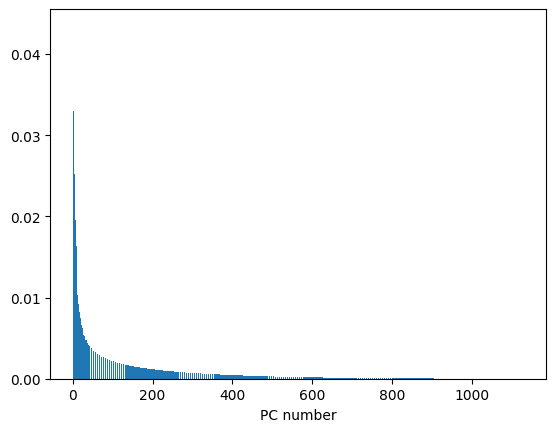

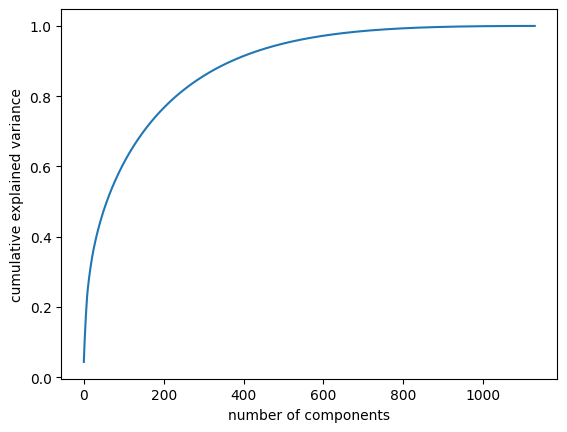


 There are 1130 principal components

 The first two PCs hold 7.638790852685823 % of the information


In [14]:
pca = PCA().fit(nat_2d)
variances=pca.explained_variance_ratio_
plt.bar(range(1,len(variances)+1),variances)
plt.xlabel('PC number')
# plt.ylabel('explained variance');
plt.show()

plt.plot(np.cumsum(variances))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

print('\n','There are',len(variances),'principal components')
print('\n','The first two PCs hold',np.sum(variances[0:2])*100,'% of the information')

We can see an exponential behaviour of the explained variance wrt the number of PCs. Moreover we observe that we have $1130$ components, coherent with the fact that the we have a dataset of $1130\times1920$ which should have a number of PCs $=\min(1130,1920)$. We also see that by projecting on the first two PCs, we retain $\approx7.64\%$ of the original information. While this may be sufficent for a graphical representation, we should take in mind that when training a model it's better to work with a more informative set of data-points.

In [15]:
pca = PCA(n_components=2)  # project from 1920 to 2 dimensions
nat_2d_pca = pca.fit_transform(nat_2d)
print(np.shape(nat_2d))
print(np.shape(nat_2d_pca))

(1130, 1920)
(1130, 2)


<ipython-input-16-616a86626a99>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


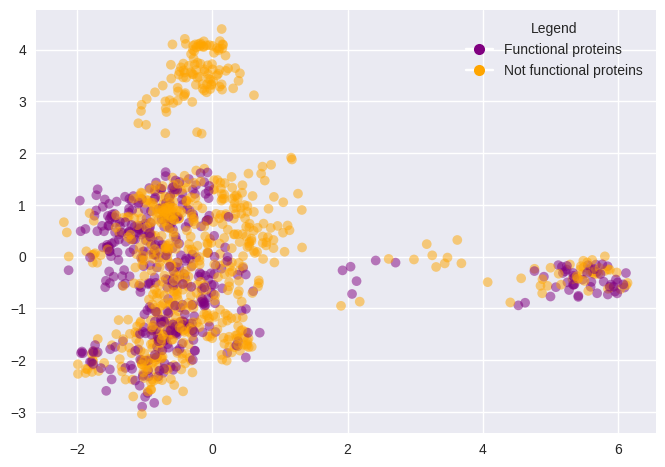

In [16]:
plt.style.use('seaborn')
colors1 = ['purple' if val == 1 else 'orange' for val in fct]
plt.scatter(nat_2d_pca[:, 0], nat_2d_pca[:, 1], c=colors1, edgecolor='none', alpha=0.5,
            label='Functional: Purple, Not functional: Orange')
# Customize the legend

legend_labels = ['Functional proteins', 'Not functional proteins']
legend_colors = ['Purple', 'Orange']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')

plt.show()

Above, we have plotted in the directions of the two main PCs and color-coded wrt the functionality of the protein sequences. It's apparent how in this plot, functional and non-functional proteins are more or less in the same regions, exception made for the top-left quadrant, which only contains non-functional protein sequences, and the top-right part of the bottom-left cluster.

In [17]:
with open('MSA_art.faa') as art_seq_faa:
  art, fct_a = parse_fasta_func(art_seq_faa)

art_enc = dict_1encoder(art)
art_2d = np.array([features_2d.flatten() for features_2d in art_enc])
art_2d_pca = pca.transform(art_2d) # Apply "old-PCA" on the artificial data

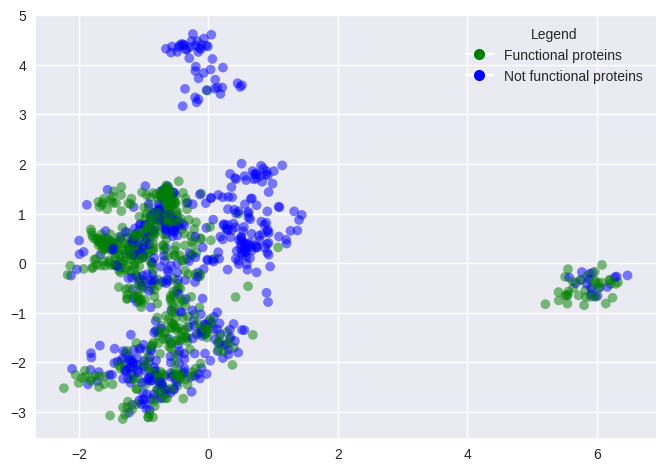

In [18]:
colors = ['green' if val == 1 else 'blue' for val in fct_a]
plt.scatter(art_2d_pca[:, 0], art_2d_pca[:, 1], c=colors, edgecolor='none', alpha=0.5,
            label='Functional: Purple, Not functional: Orange')
# Customize the legend

legend_labels = ['Functional proteins', 'Not functional proteins']
legend_colors = ['Green', 'Blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')

plt.show()

Using the `pca.transform()` command, we are able to apply the dimensional reduction to the artifical dataset using, however, the PCs fitted on the natural dataset. We cannot fit a new model because our aim is to compare the features of the two and the fitting of a new model would retrieve different PCs (which would make us visualize different characteristics). Comparing the characteristics of the two dataset, we see that indeed they exhibit a similar behaviour. In particular:
- there is a small cluster on the right of both functional and non-functional proteins;
- there is a big cluster on the bottom-left, with both functional and non-functional proteins, which exhibits a concentration of non-functional proteins in its top-right part;
- there is a small cluster of non functional proteins on the top-left.

Now let's superimpose the two plots

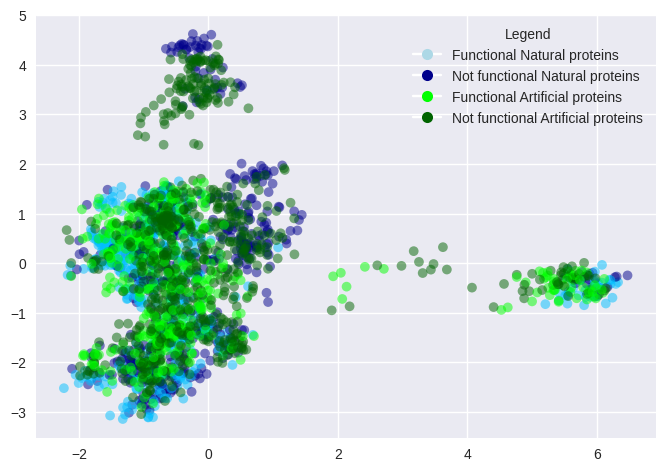

In [19]:
colors_art = ['deepskyblue' if val == 1 else 'darkblue' for val in fct_a]
plt.scatter(art_2d_pca[:, 0], art_2d_pca[:, 1], c=colors_art, edgecolor='none', alpha=0.5)

# Customize the legend
colors = ['lime' if val == 1 else 'darkgreen' for val in fct]
plt.scatter(nat_2d_pca[:, 0], nat_2d_pca[:, 1], c=colors, edgecolor='none', alpha=0.5)

# Customize the legend
legend_labels = ['Functional Natural proteins ', 'Not functional Natural proteins','Functional Artificial proteins', 'Not functional Artificial proteins']
legend_colors = ['LightBlue', 'DarkBlue','Lime', 'Darkgreen']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')

plt.show()

From this plot we can actually see that the artificial sequences occupy almost the same ''space'' in the first two principal components, signaling a probably correct generative model used in their creation. However, due to the fact that we are only watching the first two components, we are neglecting the majority of information and therefore this type of conclusion is quite premature. Moreover, consideration regarding the functionality of proteins would not be so strong as the biggest cluster contains a mixture of both functional and non-functional proteins.

In [20]:
pca3=PCA(n_components=3)
nat_2d_pca_3d = pca3.fit_transform(nat_2d)
art_2d_pca_3d = pca3.transform(art_2d)

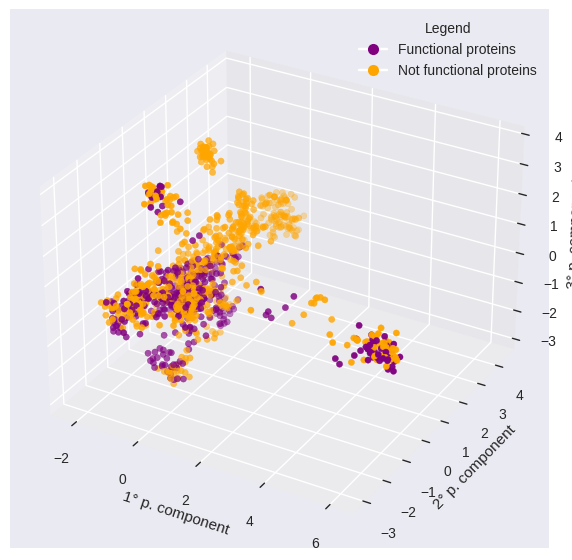

In [21]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(nat_2d_pca_3d[:,0], nat_2d_pca_3d[:,1], nat_2d_pca_3d[:,2], c=colors1)
legend_labels = ['Functional proteins', 'Not functional proteins']
legend_colors = ['Purple', 'Orange']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
ax.set_xlabel('1° p. component')
ax.set_ylabel('2° p. component')
ax.set_zlabel('3° p. component')

plt.show()

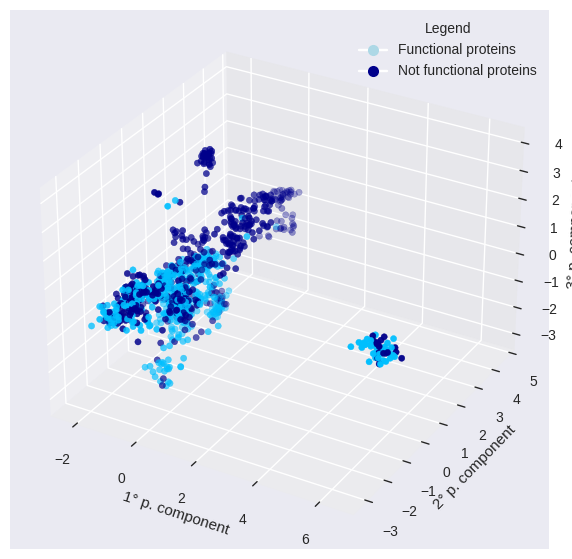

In [22]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(art_2d_pca_3d[:,0], art_2d_pca_3d[:,1], art_2d_pca_3d[:,2], c=colors_art)
legend_labels = ['Functional proteins', 'Not functional proteins']
legend_colors = ['LightBlue', 'DarkBlue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
ax.set_xlabel('1° p. component')
ax.set_ylabel('2° p. component')
ax.set_zlabel('3° p. component')

plt.show()

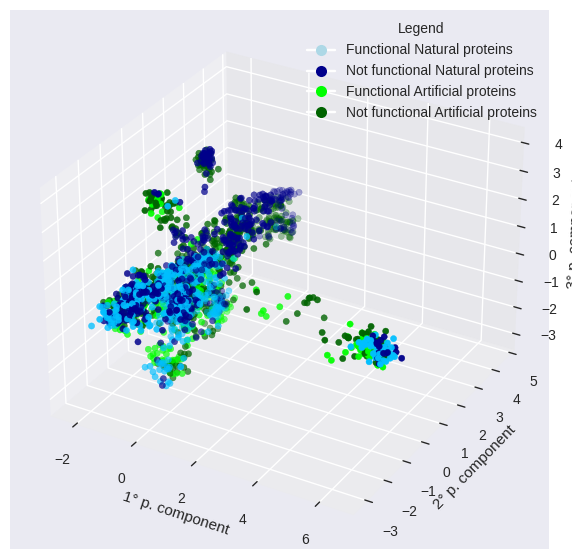

In [23]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(nat_2d_pca_3d[:,0], nat_2d_pca_3d[:,1], nat_2d_pca_3d[:,2], c=colors)
ax.scatter(art_2d_pca_3d[:,0], art_2d_pca_3d[:,1], art_2d_pca_3d[:,2], c=colors_art)
legend_labels = ['Functional Natural proteins ', 'Not functional Natural proteins','Functional Artificial proteins', 'Not functional Artificial proteins']
legend_colors = ['LightBlue', 'DarkBlue','Lime', 'Darkgreen']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
ax.set_xlabel('1° p. component')
ax.set_ylabel('2° p. component')
ax.set_zlabel('3° p. component')

plt.show()

In [24]:
np.sum(pca3.explained_variance_ratio_[0:3])

0.10217975806120053

We can also increase our dimensionality and adopt the 3 main PCs ($≈10.2\%$ of the retained information) to visualize our data. This allows us to better identify the separation of the top-right non-functional proteins of the bottom-left cluster (in the 2D-plot) from the rest.

## Task 3: Clustering sequence data


In this section we will use different clustering techniques on the natural sequences, to get some insight on the features of the dataset .

### K-Means

In [25]:
#Initializations
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


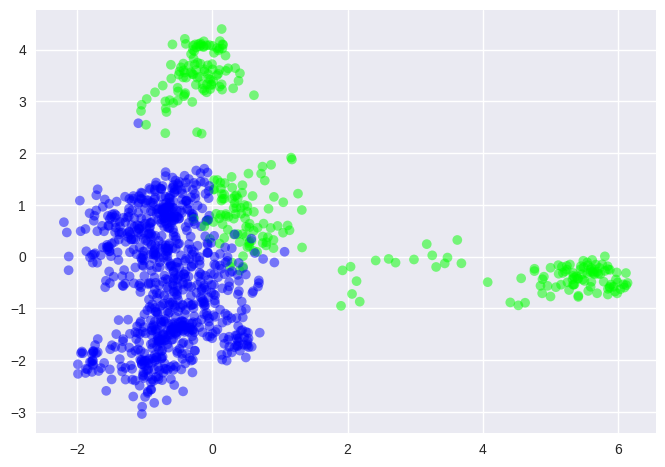

In [26]:
n_2=KMeans(2) #Clustering with 2
n_2.fit(nat_2d)
y_model_2=n_2.predict(nat_2d)
#we use PCA of before to projects
nat_pca = pca.transform(nat_2d)
plt.scatter(nat_pca[:, 0],nat_pca[:, 1], c=y_model_2, edgecolor='none', alpha=0.5,
            cmap='brg')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 1 1 1]


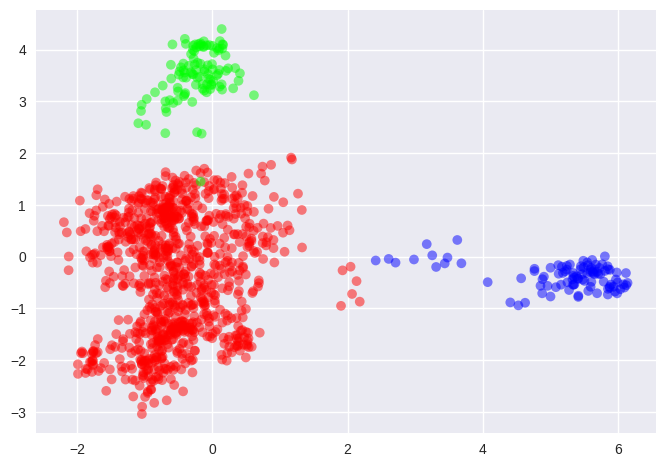

In [27]:
n_3=KMeans(3) #Clustering with 3
n_3.fit(nat_2d)
y_model_3=n_3.predict(nat_2d)
print(y_model_3)
plt.scatter(nat_pca[:, 0],nat_pca[:, 1], c=y_model_3, edgecolor='none', alpha=0.5,
            cmap='brg')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


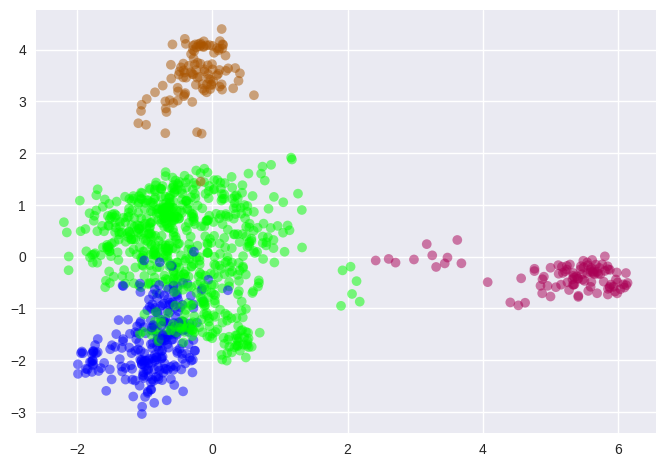

In [28]:
n_4=KMeans(4) #Clustering with 4
n_4.fit(nat_2d)
y_model_4=n_4.predict(nat_2d)
plt.scatter(nat_pca[:, 0],nat_pca[:, 1], c=y_model_4, edgecolor='none', alpha=0.5,
            cmap='brg')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


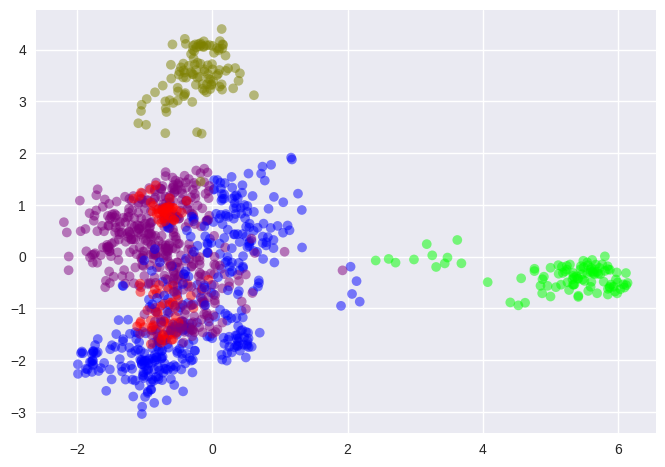

In [29]:
n_5=KMeans(5) #Clustering with 5
n_5.fit(nat_2d)
y_model_5=n_5.predict(nat_2d)
plt.scatter(nat_pca[:, 0],nat_pca[:, 1], c=y_model_5, edgecolor='none', alpha=0.5,
            cmap='brg')

**Observations**... The K means method does not work really well, we can identify some cluster but they do not have any biological meaning, they do not follow the functionality of the proteins.

### Best number of Cluster
In order to verify which is the best number of clusters, we can split in half the dataset, and see if the custers are coherents in the two halves.

#### **K-Means**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


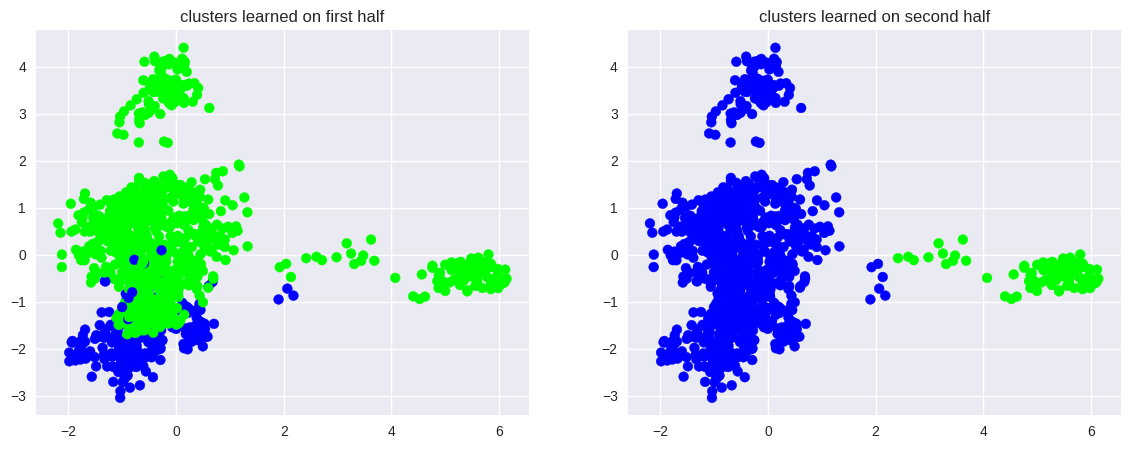

In [30]:
first_half=nat_2d[:565]
second_half=nat_2d[565:]
model_1 = KMeans(2)  # N clusters
model_1.fit(first_half)
y_model_1 = model_1.predict(nat_2d)
model_2 = KMeans(2)  # N clusters
model_2.fit(second_half)
y_model_2 = model_2.predict(nat_2d)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_1, s=50, cmap='brg')
ax[0].set_title('clusters learned on first half')

ax[1].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_2, s=50, cmap='brg')

ax[1].set_title('clusters learned on second half');
#print(np.shape(first_half))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


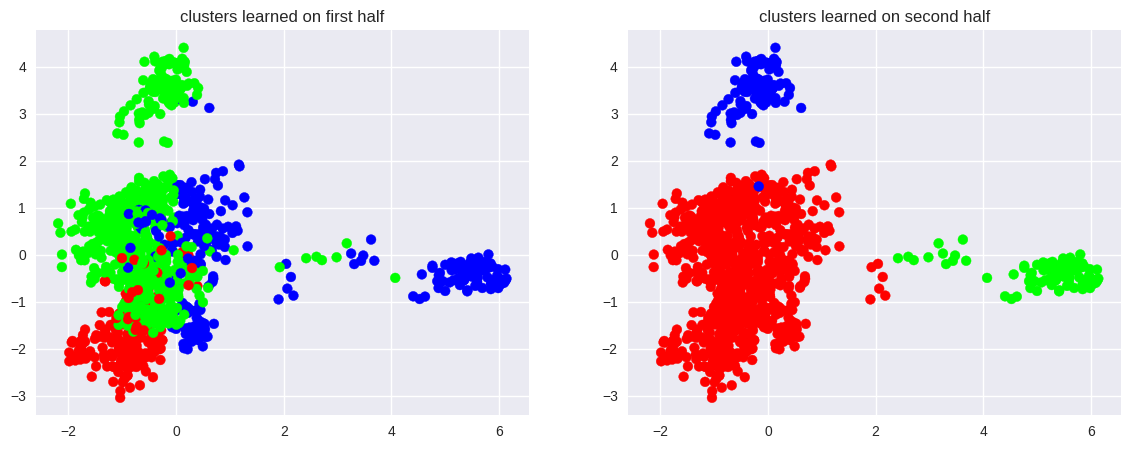

In [31]:
model_1 = KMeans(3)  # N clusters
model_1.fit(first_half)
y_model_1 = model_1.predict(nat_2d)
model_2 = KMeans(3)  # N clusters
model_2.fit(second_half)
y_model_2 = model_2.predict(nat_2d)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_1, s=50, cmap='brg')
ax[0].set_title('clusters learned on first half')

ax[1].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_2, s=50, cmap='brg')

ax[1].set_title('clusters learned on second half');

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


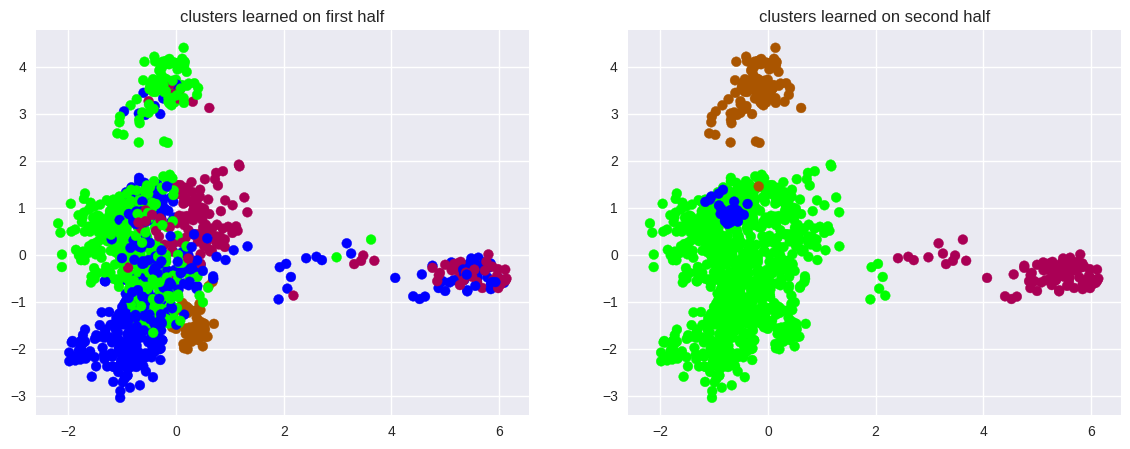

In [32]:
model_1 = KMeans(4)  # N clusters
model_1.fit(first_half)
y_model_1 = model_1.predict(nat_2d)
model_2 = KMeans(4)  # N clusters
model_2.fit(second_half)
y_model_2 = model_2.predict(nat_2d)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_1, s=50, cmap='brg')
ax[0].set_title('clusters learned on first half')

ax[1].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_2, s=50, cmap='brg')

ax[1].set_title('clusters learned on second half');

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


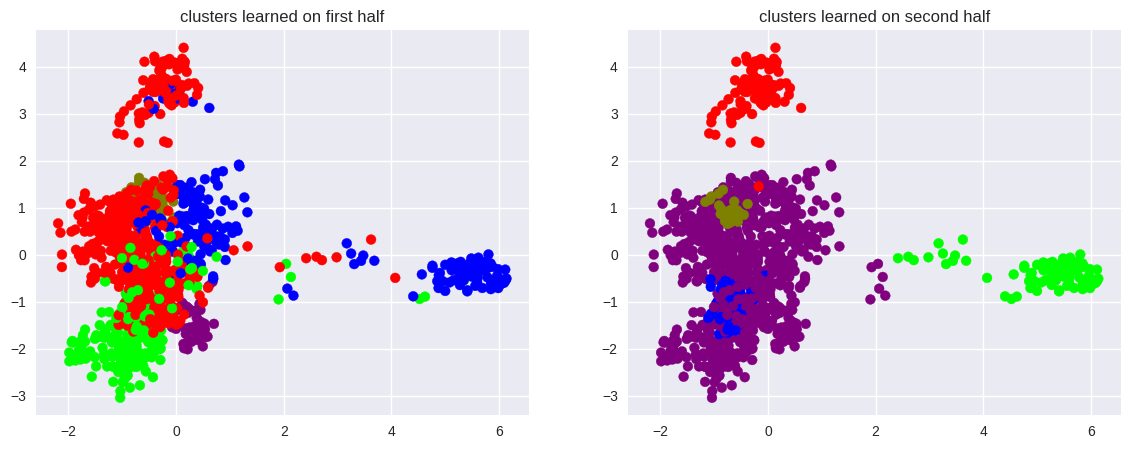

In [33]:
model_1 = KMeans(5)  # N clusters
model_1.fit(first_half)
y_model_1 = model_1.predict(nat_2d)
model_2 = KMeans(5)  # N clusters
model_2.fit(second_half)
y_model_2 = model_2.predict(nat_2d)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_1, s=50, cmap='brg')
ax[0].set_title('clusters learned on first half')

ax[1].scatter(nat_pca[:, 0], nat_pca[:, 1], c=y_model_2, s=50, cmap='brg')

ax[1].set_title('clusters learned on second half');

We can see how the clusters found in the two halves are hugely different. Moreover if we rerun the clustering procedure, the new ones will be completely different from the old ones: our algorithm is sensible to the initialization of the K centers, hence it does not have statistical meaning.  
Concluding, K-Means is not a good algorithm for this kind of dataset.

We can also compute the performance of the K-Means algorithm by computing the distortion:
the square distance of each point from the centroid defining the cluster. This is the objective function that K-Means tries to optimize.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

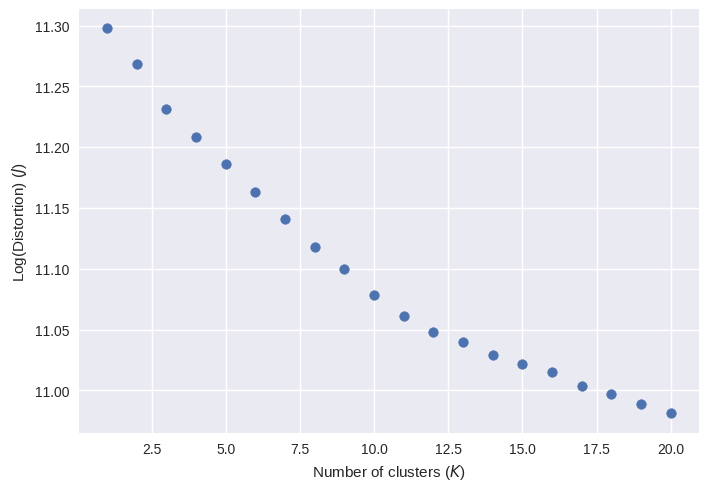

In [34]:
num_cluster=20
nc=[]
distortion=[]
for i in range(num_cluster):
    nc.append(i+1)
    model = KMeans(i+1);
    model.fit(nat_2d);
    distortion.append(model.inertia_) # Square distance of point wrt the center of the cluster

plt.scatter(nc, np.log(distortion))
plt.xlabel('Number of clusters ($K$)')
plt.ylabel('Log(Distortion) ($J$)')
plt.show()

**Comment**: increasing the number of clusters we don't see any relevent improving in the distortion which stays "large".

#### DBSCAN
Let's try an other clustering procedure, a density based one

In [35]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [36]:
def NMI(y_true, y_pred):
    # Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

In [37]:
def plotting_ax(X, y, ax):
    colors1 = np.array(y)
    sc = ax.scatter(X[:, 0], X[:, 1], c=colors1, s=4,cmap='brg')

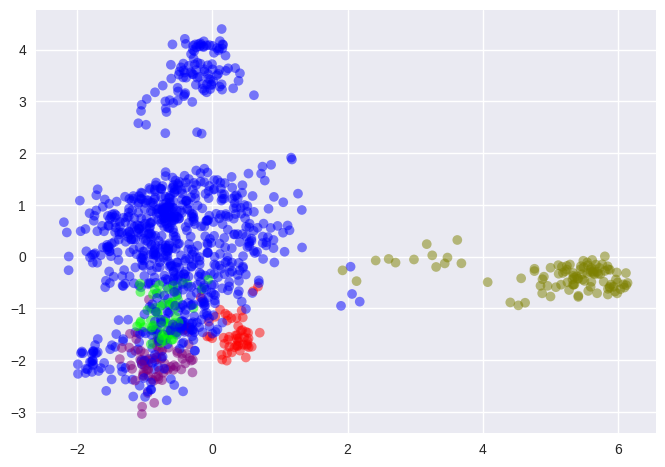

In [38]:
model=DBSCAN(eps=10, min_samples=50)
model.fit(nat_2d)
y_pred= model.labels_
plt.scatter(nat_pca[:, 0],nat_pca[:, 1], c=y_pred, edgecolor='none', alpha=0.5,
            cmap='brg')

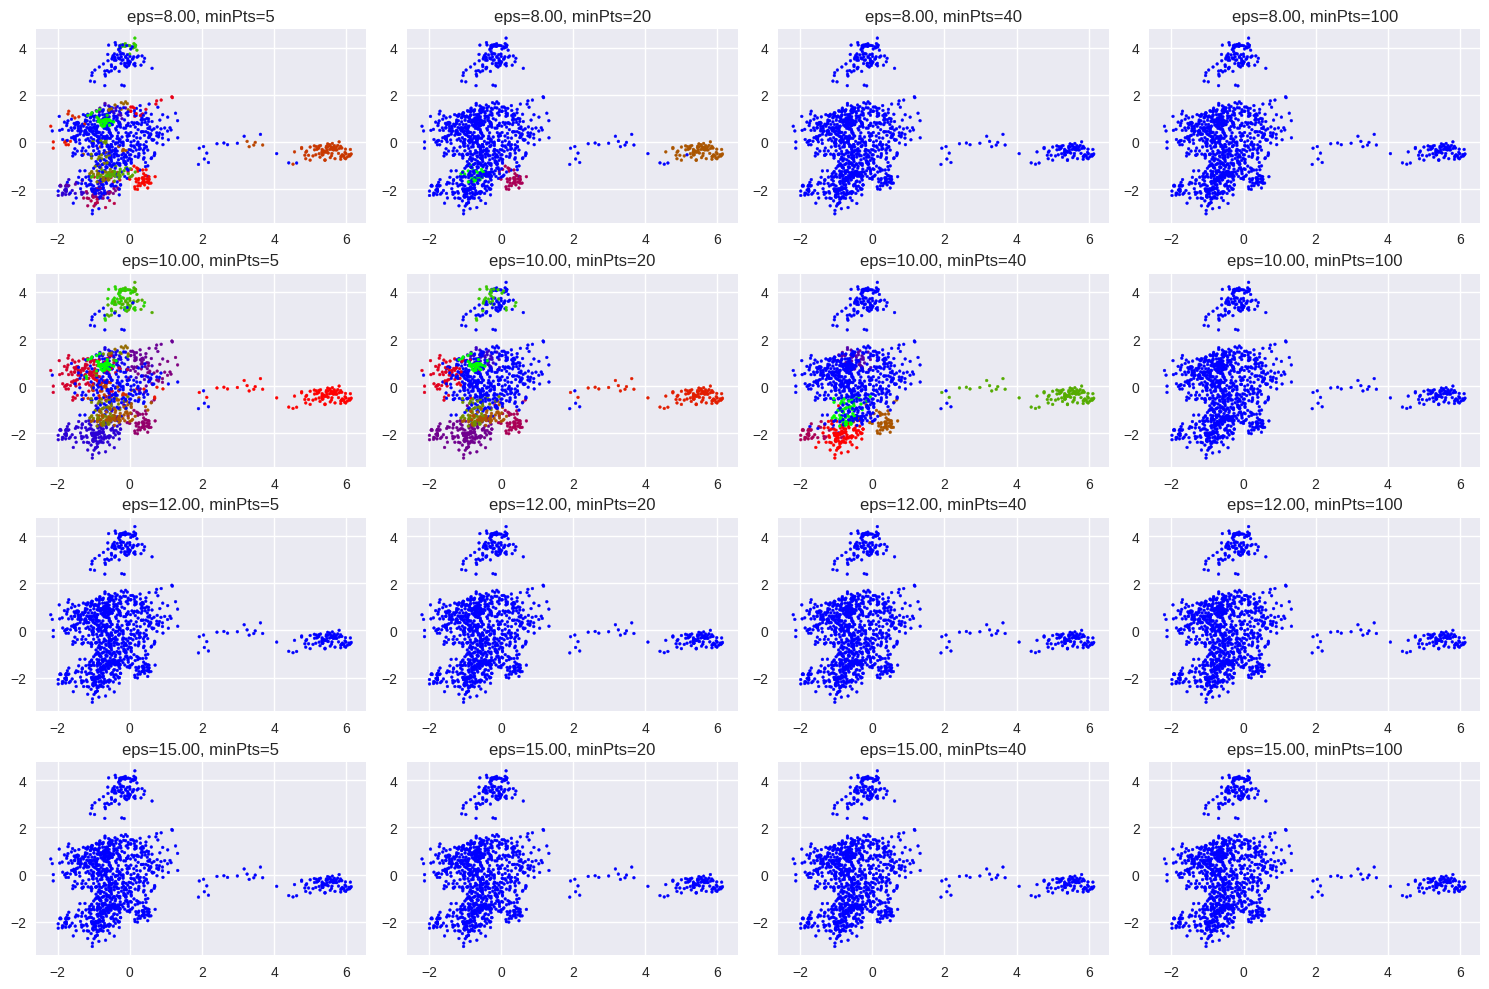

In [39]:
eps_range = [8,10,12,15]
min_sample_range = [5,20,40,100]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i in range(len(eps_range)):
    for j in range(len(min_sample_range)):
        model=DBSCAN(eps=eps_range[i],min_samples=min_sample_range[j])
        model.fit(nat_2d)
        y_pred= model.labels_
        plotting_ax(nat_pca, y_pred, ax[i,j])
        ax[i, j].set_title('eps=%.2f, minPts=%d' % (eps_range[i], min_sample_range[j]))
plt.tight_layout(h_pad=0.5)
plt.show()


**Comment**: we can see that for `eps=10` and `minPts=5` a better clustering is obtained. This is however still not sufficient as it does not fully distinguish between actually functional and non-functional proteins (e.g. for the right cluster on the right which should contain both functional and non-functional proteins).

### Unifying
We now put the natural sequences and the artificial sequences into a unique dataset and see if the data is separated in clusters of artificial and natural sequences.

#### **K-Means**

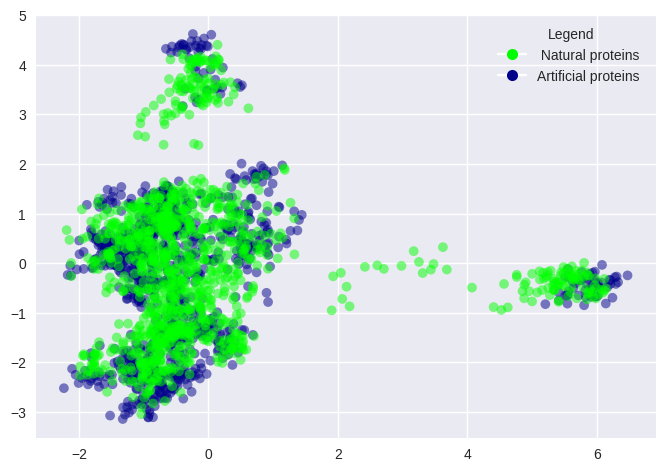

In [40]:
#Plot of the natural and the artificial sequences con the two firsts components (natural)
colors_art = ['Darkblue' for val in fct_a]
plt.scatter(art_2d_pca[:, 0], art_2d_pca[:, 1], c=colors_art, edgecolor='none', alpha=0.5)

# Customize the legend
colors = ['lime' for val in fct]
plt.scatter(nat_2d_pca[:, 0], nat_2d_pca[:, 1], c=colors, edgecolor='none', alpha=0.5)

# Customize the legend
legend_labels = [' Natural proteins ', 'Artificial proteins']
legend_colors = ['Lime','DarkBlue',]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')

plt.show()

In [41]:
all_sequences = np.concatenate((nat_2d, art_2d))
np.shape(all_sequences)

(2133, 1920)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


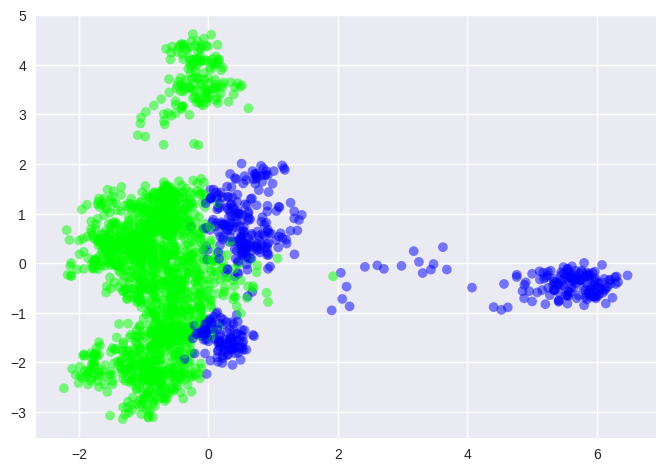

In [42]:
n_2=KMeans(2) # Clustering with 2
n_2.fit(all_sequences)
y_model_2=n_2.predict(all_sequences)
# We use PCA of before to project
all_pca = pca.transform(all_sequences)
plt.scatter(all_pca[:, 0],all_pca[:, 1], c=y_model_2, edgecolor='none', alpha=0.5,
            cmap='brg')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


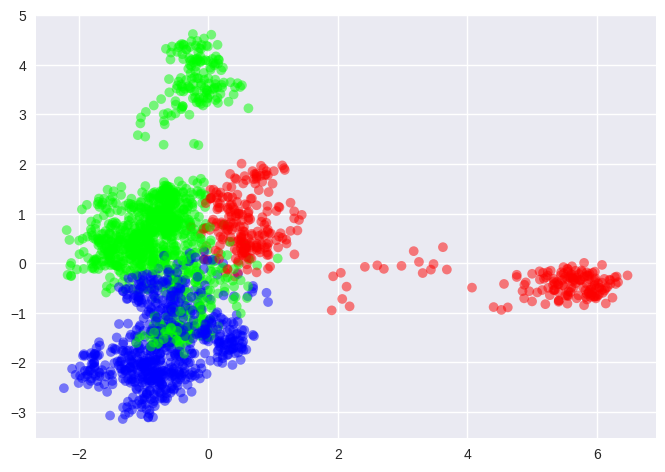

In [43]:
n_3=KMeans(3) #Clustering with 3
n_3.fit(all_sequences)
y_model_3=n_3.predict(all_sequences)
#we use PCA of before to projects
plt.scatter(all_pca[:, 0],all_pca[:, 1], c=y_model_3, edgecolor='none', alpha=0.5,
            cmap='brg')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


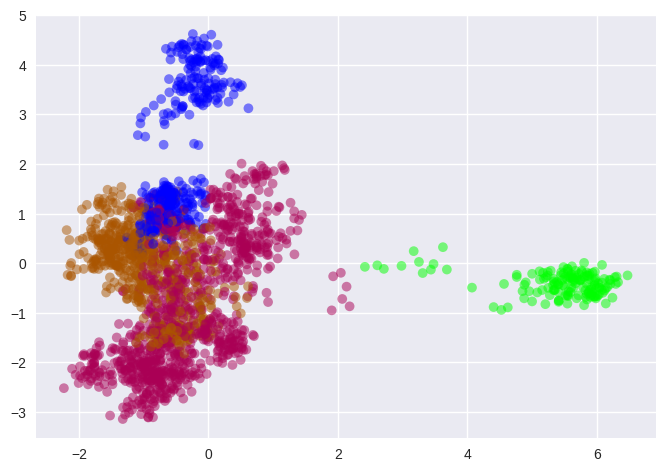

In [44]:
n_4=KMeans(4) #Clustering with 2
n_4.fit(all_sequences)
y_model_4=n_4.predict(all_sequences)
#we use PCA of before to projects
plt.scatter(all_pca[:, 0],all_pca[:, 1], c=y_model_4, edgecolor='none', alpha=0.5,
            cmap='brg')

K-Means as for the natural sequence is not very powerful and can't distinguish the natural sequence from the artificial ones. The clusters are mixed in the natural and artificial sequences.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

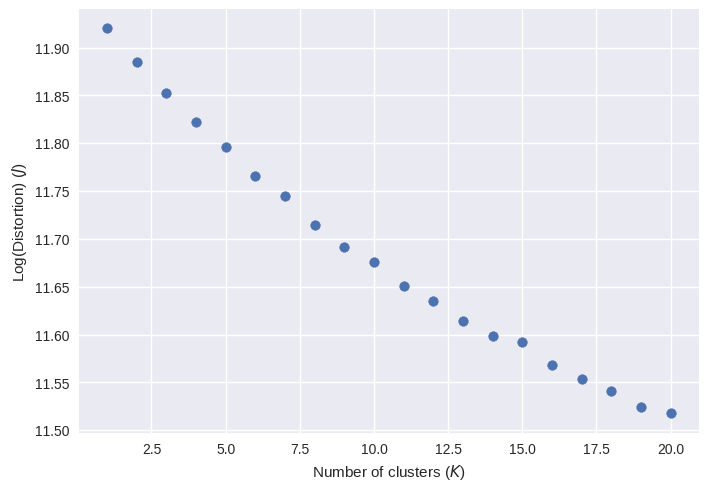

In [45]:
num_cluster=20
nc=[]
distortion=[]
for i in range(num_cluster):
    nc.append(i+1)
    model = KMeans(i+1);
    model.fit(all_sequences);
    distortion.append(model.inertia_)

plt.scatter(nc, np.log(distortion))
plt.xlabel('Number of clusters ($K$)')
plt.ylabel('Log(Distortion) ($J$)')
plt.show()

**Comment**: as before, increasing the number of clusters leaves the log-distortion basically unaltered (and high).

#### **DBSCAN**

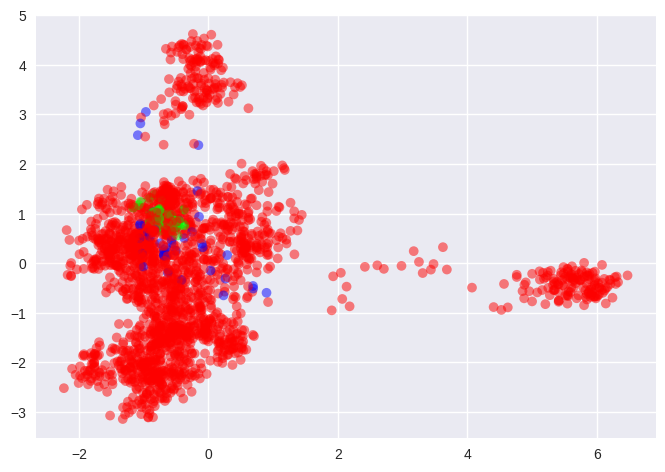

In [46]:
model_a=DBSCAN(eps=11, min_samples=50)
model_a.fit(all_sequences)
y_pred_a= model_a.labels_
plt.scatter(all_pca[:, 0],all_pca[:, 1], c=y_pred_a, edgecolor='none', alpha=0.5,
            cmap='brg')
plt.show()

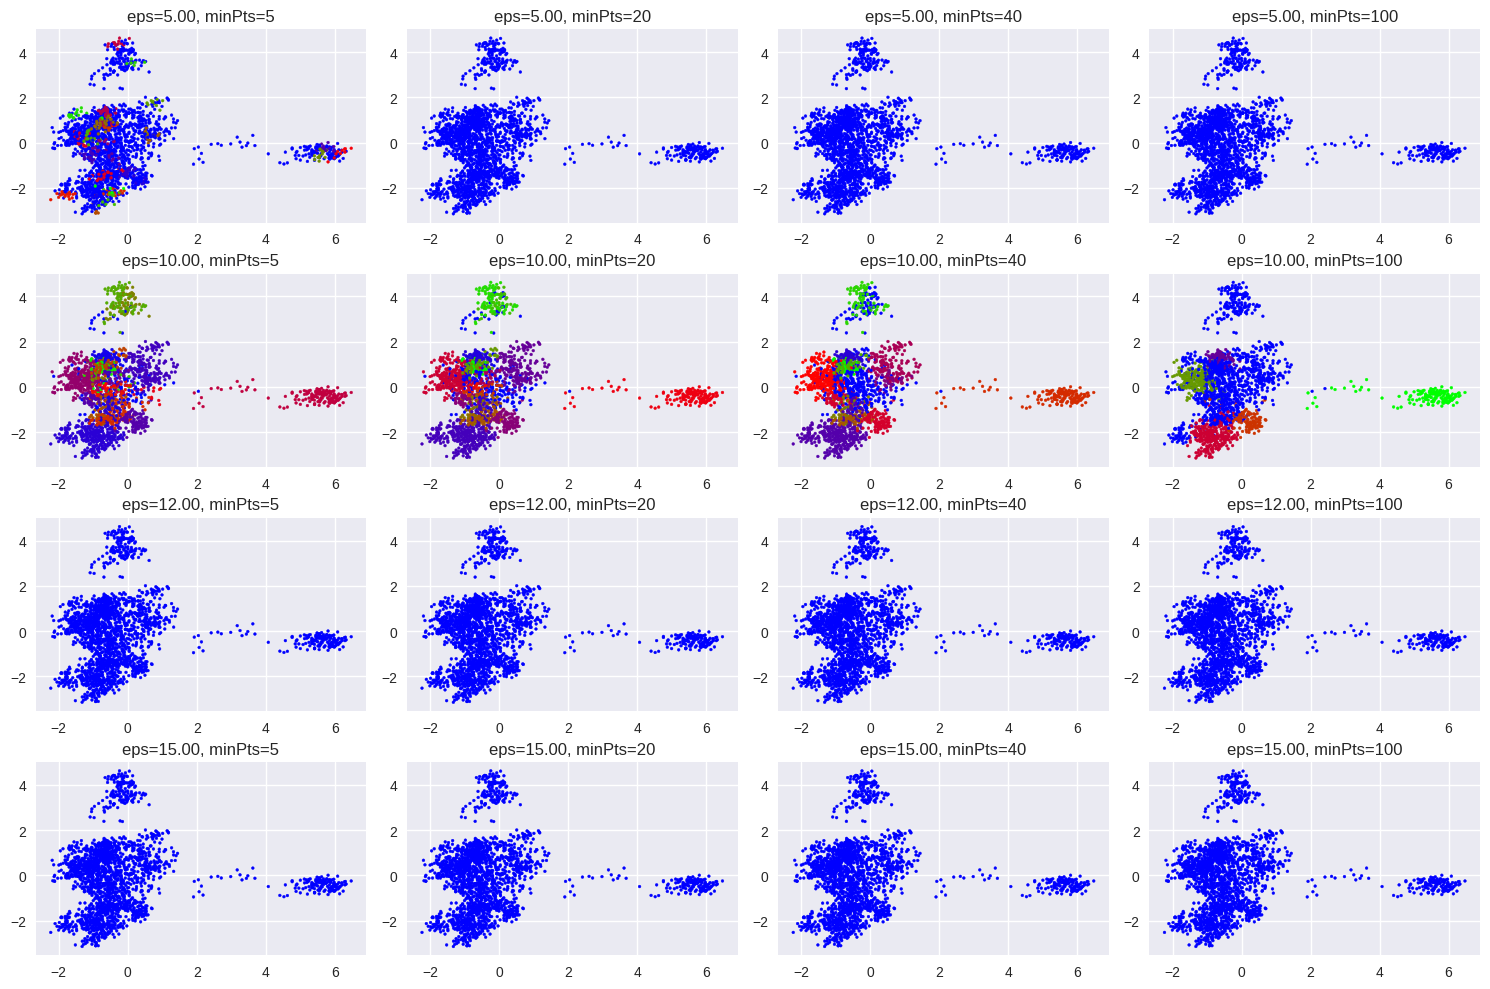

In [47]:
eps_range = [5,10,12,15]
min_sample_range = [5,20,40,100]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i in range(len(eps_range)):
    for j in range(len(min_sample_range)):
        model_a=DBSCAN(eps=eps_range[i],min_samples=min_sample_range[j])
        model_a.fit(all_sequences)
        y_pred_a= model_a.labels_
        plotting_ax(all_pca, y_pred_a, ax[i,j])
        ax[i, j].set_title('eps=%.2f, minPts=%d' % (eps_range[i], min_sample_range[j]))
plt.tight_layout(h_pad=0.5)
plt.show()

**Comment**: we see that the results are comparable with those of only natural sequences thus concluding that we are unable to capture differences between natural and artifical sequences (another signal that the generative model might be correct).

## Task 4: Predicting proteins functionality

### **Logistic Regression**

We choose as classifier the logistic regression, which is a soft classifier, hence we need to tune the cutoff (the threshold)

#### Natural sequences only

791
339
170

[[89 11]
 [22 48]]


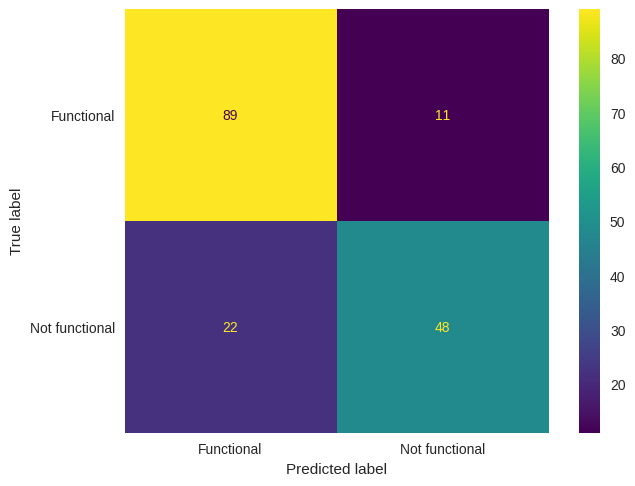


Test score = 0.8058823529411765


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

X_train_LR, X_temp_LR, y_train_LR, y_temp_LR = train_test_split(nat_2d, fct, test_size=0.30, random_state=1) #70% train
X_test_LR, X_valid_LR, y_test_LR, y_valid_LR = train_test_split(X_temp_LR, y_temp_LR, test_size=0.5, random_state=1)   # 15% test and 15% validation

print(np.shape(X_train_LR)[0])
print(np.shape(X_temp_LR)[0])
print(np.shape(X_valid_LR)[0])
print()
model_LR=LogisticRegression(max_iter=150)
model_LR.fit(X_train_LR,y_train_LR)                                #fitting the model
y_pred_LR = model_LR.predict(X_valid_LR)                           #making prediction on validation
prob=model_LR.predict_proba(X_valid_LR)
cm = confusion_matrix(y_valid_LR, y_pred_LR)


print(cm)

disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()

print()
print("Test score =",model_LR.score(X_valid_LR, y_valid_LR))

(170,)
[[89 11]
 [22 48]]


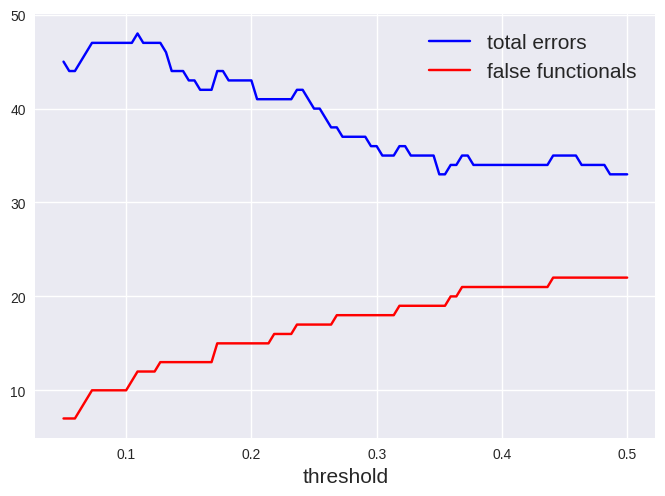

In [49]:
total_error = np.zeros(0) #tuning the threshold
false_functional = np.zeros(0)
threshold=np.linspace(0.05,0.5,100)

y_treshold=np.zeros(np.shape(X_valid_LR)[0])

print(np.shape(y_valid_LR))

for thr in threshold:
  y_treshold=np.zeros(np.shape(X_valid_LR)[0])
  for i in range(len(y_treshold)):
    if prob[i,1]>=thr:
      y_treshold[i]=1
    else:
      y_treshold[i]=0
      #print(y_treshold)

  cm = confusion_matrix(y_valid_LR, y_treshold)
  # print(cm)
  total_error = np.append(total_error,cm[0,1]+cm[1,0])
  # print(total_error)
  false_functional = np.append(false_functional, cm[1,0])
print(cm)
plt.plot(threshold,total_error, c='blue', label='total errors')
plt.plot(threshold, false_functional, c='red',label='false functionals')
plt.xlabel('threshold', fontsize=15)
plt.legend(loc="upper right", fontsize=15)
plt.show()

At `T=0.1` we have 10 false functionals instead of 22 but we have payed the price of an higher total error!

Now we apply our model on the test set and check the confusion matrix.

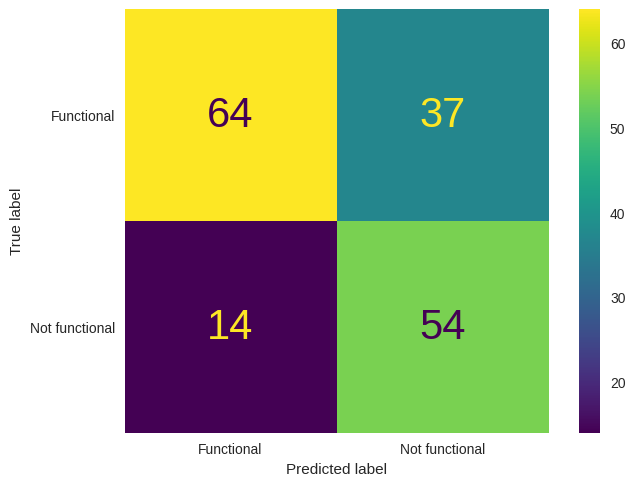

In [50]:
prob=model_LR.predict_proba(X_test_LR)
y_treshold=np.zeros(np.shape(X_test_LR)[0])

for i in range(len(prob)):
    if prob[i,1]>=0.1:
      y_treshold[i]=1
    else:
      y_treshold[i]=0

cm = confusion_matrix(y_test_LR, y_treshold)
disp=ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()

In order to not lose important data, we can retrain the model including the validation set into the training dataset.

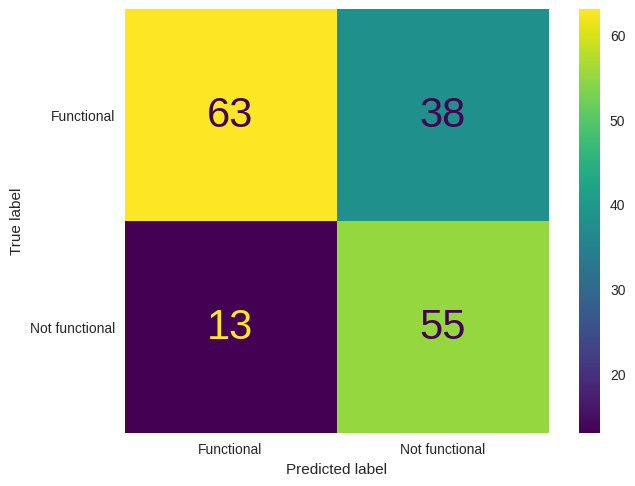

In [51]:
# X_train, X_test, y_train, y_test = train_test_split(nat_2d, fct, test_size=0.15, random_state=1)

model_LR=LogisticRegression(max_iter=150)
model_LR.fit(np.concatenate((X_train_LR,X_valid_LR)),np.concatenate((y_train_LR,y_valid_LR)))       #fitting the model
y_pred = model_LR.predict(X_valid_LR)

prob=model_LR.predict_proba(X_test_LR)
y_treshold=np.zeros(np.shape(X_test_LR)[0])

for i in range(len(prob)):
    if prob[i,1]>=0.1:
      y_treshold[i]=1
    else:
      y_treshold[i]=0

cm = confusion_matrix(y_test_LR, y_treshold)
disp=ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()

It's not an big improvement. Let's see how it behaves on the artificial sequences, retraining our model over the whole dataset of natural sequences using the artifical sequences as the train/valid sets.

#### Natural + Artificial

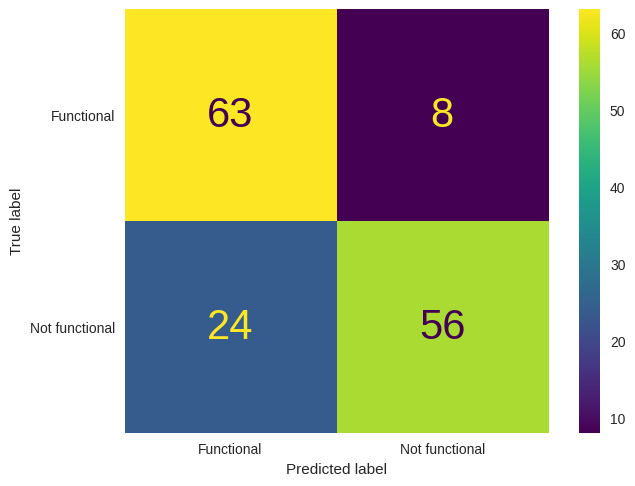

Test score = 0.7880794701986755


In [52]:
model_LR=LogisticRegression(max_iter=200)
model_LR.fit(nat_2d,fct)                                #fitting the model
X_test_a, X_valid_a, y_test_a, y_valid_a = train_test_split(art_2d, fct_a, test_size=0.15, random_state=1)   # 85 test and 15% validation
y_pred_a = model_LR.predict(X_valid_a)                           #making prediction on validation
prob=model_LR.predict_proba(X_valid_a)

cm = confusion_matrix(y_valid_a, y_pred_a)
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()

print("Test score =",model_LR.score(X_valid_a, y_valid_a))

(151,)
[[63  8]
 [24 56]]


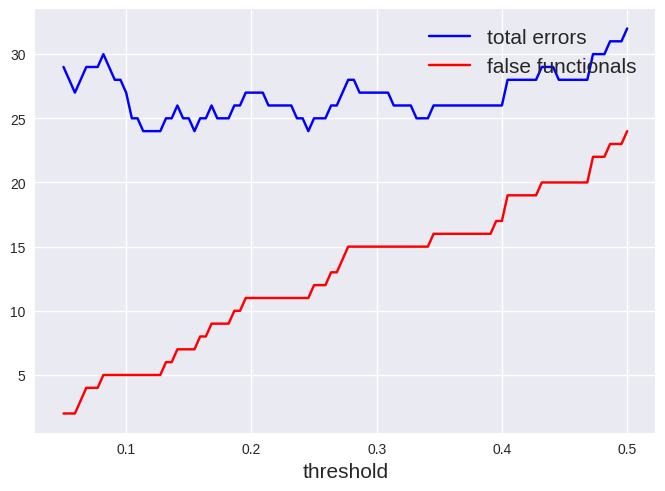

In [53]:
total_error = np.zeros(0)
false_functional = np.zeros(0)
threshold=np.linspace(0.05,0.5,100)

y_treshold=np.zeros(np.shape(X_valid_a)[0])

print(np.shape(y_valid_a))

for thr in threshold:
  y_treshold=np.zeros(np.shape(X_valid_a)[0])
  for i in range(len(y_treshold)):
    if prob[i,1]>=thr:
      y_treshold[i]=1
    else:
      y_treshold[i]=0
      #print(y_treshold)
  cm = confusion_matrix(y_valid_a, y_treshold)
  # print(cm)
  total_error = np.append(total_error,cm[0,1]+cm[1,0])
  # print(total_error)
  false_functional = np.append(false_functional, cm[1,0])
print(cm)
plt.plot(threshold,total_error, c='blue', label='total errors')
plt.plot(threshold, false_functional, c='red',label='false functionals')
# plt.plot(np.ones(10)*0.12,np.linspace(40,100,10))
plt.xlabel('threshold', fontsize=15)
plt.legend(loc="upper right", fontsize=15)
plt.show()

We decide to pick a threshold of `T=0.11`

Test score = 0.7828638497652582


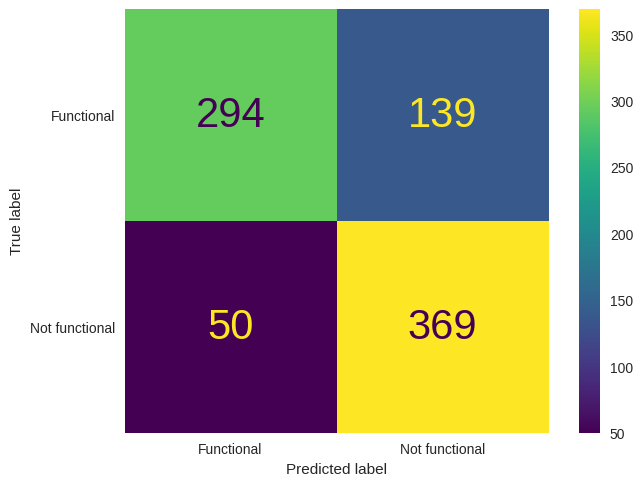

In [54]:
prob=model_LR.predict_proba(X_test_a)
print("Test score =",model_LR.score(X_test_a, y_test_a))
y_treshold=np.zeros(np.shape(X_test_a)[0])

for i in range(len(prob)):
    if prob[i,1]>=0.11:
      y_treshold[i]=1
    else:
      y_treshold[i]=0

cm = confusion_matrix(y_test_a, y_treshold)
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)

The logistic regression is not very powerful for this kind of dataset, we have 189  proteins which are wrongly classified.

(852,)
Test score = 0.7816901408450704


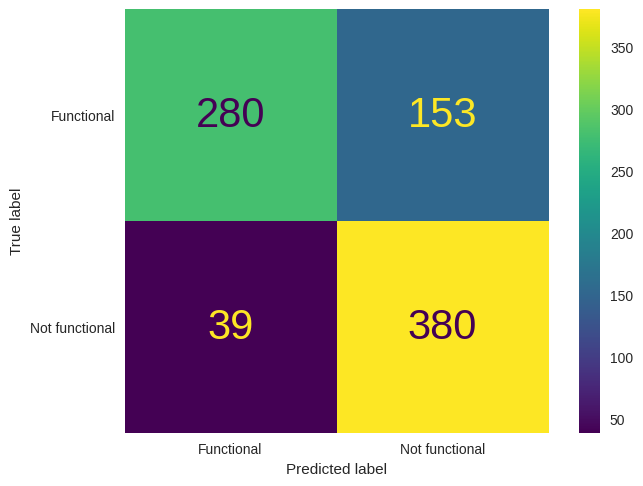

In [55]:
model_LR=LogisticRegression(max_iter=200)
model_LR.fit(np.concatenate((nat_2d,X_valid_a)),np.concatenate((fct,y_valid_a)))       #fitting the model natural+artificial (validation set)

prob=model_LR.predict_proba(X_test_a)
y_treshold=np.zeros(np.shape(X_test_a)[0])

for i in range(len(prob)):
    if prob[i,1]>=0.11:
      y_treshold[i]=1
    else:
      y_treshold[i]=0

cm = confusion_matrix(y_test_a, y_treshold)
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
print(np.shape(y_treshold))
print("Test score =",model_LR.score(X_test_a, y_test_a))

Training the model on the entire dataset of natural sequences, now we misclassified 192 proteins.

### **AdaBoost**

Given that the results of Logistic Regression are not very accurate, we implement a different classifier: the AdaBoost technique.

#### Natural sequences only

In [56]:
# Initialization
from sklearn.tree import DecisionTreeClassifier # Weak classifier
from sklearn.ensemble import AdaBoostClassifier # Strong ensemble classifier (Boosting)
from sklearn.model_selection import cross_val_score

In [57]:
#cross validation to decide the max depth
cv=[]
for j in np.array((10,20,30,40,50)):
  for i in np.array((5,10,15,20,30)):
    scores = cross_val_score(AdaBoostClassifier(n_estimators=j,estimator=DecisionTreeClassifier(max_depth=i,random_state=1),random_state=10), nat_2d, fct, cv=3, scoring='accuracy')
    # Print average accuracy across folds
    print("Average Cross-Validation Accuracy:", np.mean(scores), "depth=",i,"n_estimators=",j)
  print()

Average Cross-Validation Accuracy: 0.5911286378087551 depth= 5 n_estimators= 10
Average Cross-Validation Accuracy: 0.6282756739469872 depth= 10 n_estimators= 10
Average Cross-Validation Accuracy: 0.615894896250729 depth= 15 n_estimators= 10
Average Cross-Validation Accuracy: 0.6097150892638786 depth= 20 n_estimators= 10
Average Cross-Validation Accuracy: 0.6105992625618452 depth= 30 n_estimators= 10

Average Cross-Validation Accuracy: 0.5920316233045506 depth= 5 n_estimators= 20
Average Cross-Validation Accuracy: 0.5990603307184378 depth= 10 n_estimators= 20
Average Cross-Validation Accuracy: 0.6105922079876592 depth= 15 n_estimators= 20
Average Cross-Validation Accuracy: 0.6097150892638786 depth= 20 n_estimators= 20
Average Cross-Validation Accuracy: 0.6105992625618452 depth= 30 n_estimators= 20

Average Cross-Validation Accuracy: 0.5937858607521117 depth= 5 n_estimators= 30
Average Cross-Validation Accuracy: 0.6123487969599489 depth= 10 n_estimators= 30
Average Cross-Validation Accur

The best choice seems to be `maxdepht=10` and the `n_estimators=10`.



In [58]:
# Creation of classifier
weak_classifier = DecisionTreeClassifier(max_depth=10, random_state=1)
strong_classifier = AdaBoostClassifier(n_estimators=10, estimator=weak_classifier,random_state=10)

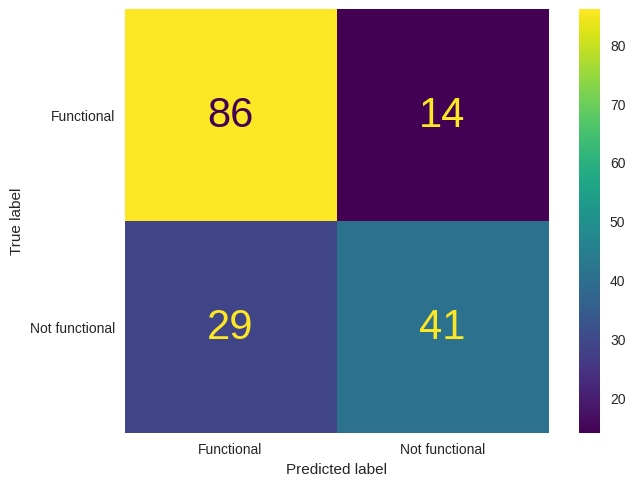


Test score = 0.7470588235294118


In [59]:
X_train_AB, X_temp_AB, y_train_AB, y_temp_AB = train_test_split(nat_2d, fct, test_size=0.30, random_state=1)
X_test_AB, X_valid_AB, y_test_AB, y_valid_AB = train_test_split(X_temp_AB, y_temp_AB, test_size=0.5, random_state=1)   # 15% test and 15% validation

model_Ada = strong_classifier.fit(X_train_AB, y_train_AB) # Fitting on training data
y_pred_AB = model_Ada.predict(X_valid_AB)

cm = confusion_matrix(y_valid_AB, y_pred_AB)
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()

print()
print("Test score =",model_Ada.score(X_valid_AB, y_valid_AB))

We obtain a very nice result with a test score on the validation set $\approx75\%$!

Now we'll retrain our model on the train+validation set given that we've fixed `n_estimators=10`,and `max_depth=10`.

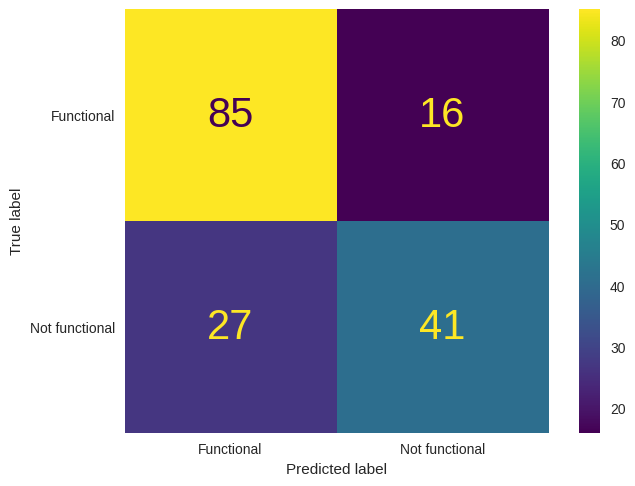

In [60]:
# X_train, X_test, y_train, y_test = train_test_split(nat_2d, fct, test_size=0.15, random_state=1)

strong_classifier = AdaBoostClassifier(n_estimators=10, estimator=weak_classifier,random_state=10)
model_Ada = strong_classifier.fit(np.concatenate((X_train_AB,X_valid_AB)), np.concatenate((y_train_AB,y_valid_AB)))
y_pred_AB = model_Ada.predict(X_test_AB)

cm = confusion_matrix(y_test_AB, y_pred_AB)
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()

We can already see a slight improvement in terms of misclassified proteins.

#### Natural + Artificial

Now let's see what happens when we consider both the natural and artificial datasets.

In [61]:
X_test, X_valid, y_test, y_valid = train_test_split(art_2d, fct_a, test_size=0.15, random_state=1)

#cross validation to decide the max depth
cv=[]
for j in np.array((10,20,30,40,50)):
  for i in np.array((5,10,15,20,30)):
    scores = cross_val_score(AdaBoostClassifier(n_estimators=j,estimator=DecisionTreeClassifier(max_depth=i,random_state=1),random_state=10), np.concatenate((nat_2d,X_valid)), np.concatenate((fct,y_valid)), cv=3, scoring='accuracy')
    # Print average accuracy across folds
    print("Average Cross-Validation Accuracy:", np.mean(scores), "depth=",i,"n_estimators=",j)
  print()

Average Cross-Validation Accuracy: 0.5331772053083529 depth= 5 n_estimators= 10
Average Cross-Validation Accuracy: 0.580015612802498 depth= 10 n_estimators= 10
Average Cross-Validation Accuracy: 0.5456674473067915 depth= 15 n_estimators= 10
Average Cross-Validation Accuracy: 0.5589383294301327 depth= 20 n_estimators= 10
Average Cross-Validation Accuracy: 0.5199063231850117 depth= 30 n_estimators= 10

Average Cross-Validation Accuracy: 0.5487900078064013 depth= 5 n_estimators= 20
Average Cross-Validation Accuracy: 0.5729898516783763 depth= 10 n_estimators= 20
Average Cross-Validation Accuracy: 0.5589383294301327 depth= 15 n_estimators= 20
Average Cross-Validation Accuracy: 0.580015612802498 depth= 20 n_estimators= 20
Average Cross-Validation Accuracy: 0.5199063231850117 depth= 30 n_estimators= 20

Average Cross-Validation Accuracy: 0.5683060109289617 depth= 5 n_estimators= 30
Average Cross-Validation Accuracy: 0.5776736924277908 depth= 10 n_estimators= 30
Average Cross-Validation Accura

We can see that a better behaviour is obatined for `n_estimators=50` and `max_depth=10`.

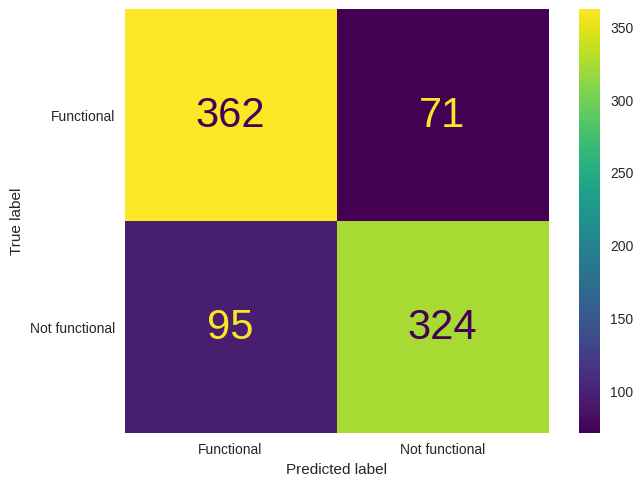

(852,)

Test score = 0.8051643192488263


In [62]:
weak_classifier = DecisionTreeClassifier(max_depth=10, random_state=1)
strong_classifier = AdaBoostClassifier(n_estimators=50, estimator=weak_classifier,random_state=10)
model_Ada = strong_classifier.fit(np.concatenate((nat_2d,X_valid)), np.concatenate((fct,y_valid)))
y_pred = model_Ada.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm, display_labels=['Functional','Not functional'])
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()
print(np.shape(y_pred))
print()
print("Test score =",model_Ada.score(X_test, y_test))

We can see how AdaBoost is able to retrieve fewer wrong predictions at the cost of giving more false functionals than Logistic Regression. It might therefore seem better to use Logistic Regression for the cases in which the correct prediction of false functionals is more important than having fewer errors globally.

**IMPORTANT CONSIDERATION:** one should also take into account the possibility of overfitting or underfitting. These situations can be studied by analyzing (e.g.) the training and validation curves. Whilst acknowledging the possible presence of these issues, due to a lack of time we've been unable to look at them in depth. This paragraph is thus present to stress that we are aware that one should look into the above issue to ensure the correctness of the classifier.

## Task 5: Generating artificial sequences

### Boltzmann Machine Learning

**Maximum Likelihood estimator**

We start with the assumption that we can model proteins via a 1D *Potts model* with $L=96$ sites and $q=21$ "colors" (corresponding to the aminoacids) in which we ignore the presence of external fields $h_i(a_i)$ but only consider interactions $J_{ij}(a_i,a_j)$, thus leading to the following Hamiltonian:

\begin{equation*}
\beta\mathcal{H}=-\sum_{i, j = 1}^L J_{i, j}(x_i, x_j) = -\sum_{i, j = 1}^L\sum_{a,b=1}^q J_{i, j}(a,b)\delta_{x_i,a}\delta_{x_j,b}
\end{equation*}

Our goal is to find the set of parameters $J_{i j}(a, b)$ for all $i, j \in \{1, \dots, L\}$, $a, b \in \{1, \dots, q\}$ that maximises the likelihood:

\begin{align*}
	\mathcal{L}\left(\boldsymbol{J} | \left\{\boldsymbol{x}^{(m)}\right\}_{m = 1}^M\right) & = P\left(\left\{\boldsymbol{x}^{(m)}\right\}_{m = 1}^M | \boldsymbol{J}\right)
	= \prod_{m = 1}^{M} P\left(\boldsymbol{x}^{(m)} | \boldsymbol{J}\right) = \\
	& = \prod_{m = 1}^{M} \frac{1}{Z(\boldsymbol{J})} \exp\left[\sum_{i, j = 1}^L\sum_{a, b = 1}^q J_{i, j}(a, b) \ \delta_{x_i^{(m)}, a} \ \delta_{x_j^{(m)}, b}\right] = \\
	& = \frac{1}{Z(\boldsymbol{J})^M} \exp\left[\sum_{m = 1}^M \sum_{i, j = 1}^L \sum_{a, b = 1}^q J_{i, j}(a, b) \ \delta_{x_i^{(m)}, a}\ \delta_{x_j^{(m)}, b}\right],
\end{align*}

where

\begin{equation*}
	Z(\boldsymbol{J}) = \sum_{x_1, \dots, x_L = 1}^q \exp\left[\sum_{i, j = 1}^L \sum_{a, b = 1}^q J_{i, j}(a, b) \ \delta_{x_i, a} \ \delta_{x_j, b}\right]
\end{equation*}

is the normalization constant.
To this aim we compute the log-likelihood (and divide by $M$), getting

\begin{equation*}
	l\left(\boldsymbol{J} | \left\{\boldsymbol{x}^{(m)}\right\}_{m = 1}^M\right) = \left(\frac{1}{M} \sum_{m=1}^M\sum_{i, j = 1}^L\sum_{a, b = 1}^q J_{i, j}(a, b) \ \delta_{x_i^{(m)}, a} \ \delta_{x_j^{(m)}, b}\right) - \log{Z(\boldsymbol{J})}.
\end{equation*}

Deriving w.r.t. $J_{i, j}(a, b)$, for fixed $i, j, a, b$, we get

\begin{equation*}
	\frac{\partial l\left(\boldsymbol{J} | \left\{\boldsymbol{x}^{(m)}\right\}_{m = 1}^M\right)}{\partial J_{i,j}(a,b)}
	= \left(\frac{1}{M} \sum_{m = 1}^M \delta_{x_i^{(m)}, a} \ \delta_{x_j^{(m)}, b}\right) - \frac{1}{Z(\boldsymbol{J})} \frac{\partial Z(\boldsymbol{J})}{\partial J_{i, j}(a, b)}
\end{equation*}

where

\begin{equation*}
	\frac{\partial Z(\boldsymbol{J})}{\partial J_{i, j}(a, b)} = \sum_{x_1, \dots, x_L = 1}^q \delta_{x_i,a} \ \delta_{x_j,b} \ \exp\left[\sum_{i, j = 1}^L\sum_{a, b = 1}^q J_{i, j}(a, b) \ \delta_{x_i, a} \ \delta_{x_j, b}\right].
\end{equation*}

Plugging into the previous expression, we find that

\begin{align*}
	\frac{\partial l\left(\boldsymbol{J} | \left\{\boldsymbol{x}^{(m)}\right\}_{m = 1}^M\right)}{\partial J_{i,j}(a,b)} & = \left(\frac{1}{M} \sum_{m = 1}^M \delta_{x_i^{(m)}, a} \ \delta_{x_j^{(m)}, b}\right) - \sum_{x_1, \dots, x_L = 1}^q \delta_{x_i,a} \ \delta_{x_j,b} \ \frac{1}{Z(\boldsymbol{J})} \exp\left[\sum_{i, j = 1}^L\sum_{a, b = 1}^q J_{i, j}(a, b) \ \delta_{x_i, a} \ \delta_{x_j, b}\right] = \\
	& = \langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{data}} - \langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{model}}
\end{align*}

where $\langle \cdot \rangle_{\rm{data}}$ stands for the empirical mean of the observations, $\langle \cdot \rangle_{\rm{model}}$ is the mean of $\delta_{(x_i, x_j), (a, b)}$ computed on the distribution $P(\boldsymbol{x} | \boldsymbol{J})$ and $\delta$ denotes again the
Kronecker delta

\begin{equation*}
	\delta_{(x_i, x_j), (a, b)} =
	\begin{cases}
		1 & \text{if } x_i = a \text{ and } x_j = b \\
		0 & \text{otherwise}
	\end{cases}.
\end{equation*}

Hence, in order to find the value of $J$ for which the function $\mathcal{L}\left(\boldsymbol{J} | \left\{\boldsymbol{x}^{(m)}\right\}_{m = 1}^M\right)$ is maximised we have to impose

\begin{equation*}
	\frac{\partial l\left(\boldsymbol{J} | \left\{\boldsymbol{x}^{(m)}\right\}_{m = 1}^M\right)}{\partial J_{i,j}(a,b)} = 0 \iff \langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{data}} = \langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{model}}.
\end{equation*}

**Boltzmann machine learning scheme**

What we found can be exploited iteratively to estimate the coupling matrices through a gradient ascent algorithm (Boltzmann machine learning): $\forall i, j, a, b$

\begin{align*}
	& J_{i, j}^{0}(a, b) = 0, \\
	& J_{i, j}^{t + 1}(a, b) \leftarrow J_{i, j}^{t}(a, b) + \lambda \left[\langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{data}} - \langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{model}(t)}\right], \ \forall t \geq 0
\end{align*}

It is clear that at every step $t$ we should perform the computation of $\langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{model(t)}}$ which costs $O(q^L)$, so we bypass the problem using a Metropolis-Hastings
algorithm to sample from

\begin{equation*}
	\pi_t\left(\boldsymbol{x}\right) = \frac{1}{Z(\boldsymbol{J}^t)} \exp\left(\sum_{i, j = 1}^L J_{i, j}^{t}(x_i, x_j)\right)
\end{equation*}

and later estimate $\langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{model(t)}}$:
- `set` an initial condition $\boldsymbol{x}^{0}$ (extract randomly from the $q^L$ possible configurations);

- `for` $s \in \{1, \dots, T_{\rm{burn-in}} + T_{\rm{tot}} \times T_{\rm{wait}}\}$:

	1. `draw` $\boldsymbol{x} \sim p\left(\boldsymbol{x}|\boldsymbol{x}^{(s - 1)}\right)$ with probability $\frac{1}{q L}$ (we draw one of the $L$ positions and change between the $q$ colors)

	2. `compute` the acceptance ratio $a\left(\boldsymbol{x}|\boldsymbol{x}^{(s - 1)}\right)$:
	\begin{align*}
		a\left(\boldsymbol{x}|\boldsymbol{x}^{(s - 1)}\right) & = \min\left\{1, \frac{p\left(\boldsymbol{x}^{(s - 1)}|\boldsymbol{x}\right) \pi_t(x)}{p\left(\boldsymbol{x}|\boldsymbol{x}^{(s - 1)}\right) \pi_t(x^{(s - 1)})}\right\} = \\
		& = \min\left\{1, \exp\left[\sum_{i, j = 1}^L J_{i, j}^{t}\left(x_i, x_j\right) - J_{i, j}^{t}\left(x^{(s - 1)}_i, x^{(s - 1)}_j\right)\right]\right\},
	\end{align*}

	Now assuming
	\begin{equation*}
		\boldsymbol{x} = \left(x^{(s - 1)}_1, \dots, x^{(s - 1)}_{k - 1}, x^{\text{new}}_{k}, x^{(s - 1)}_{k + 1}, \dots, x^{(s - 1)}_{L}\right),
	\end{equation*}

	we have
  
	\begin{align*}
		a\left(\boldsymbol{x}|\boldsymbol{x}^{(s - 1)}\right) = \min\Bigg\{1,\, & \exp\Bigg[\sum_{i \neq k} J_{i, k}^{t}\left(x^{(s - 1)}_i, x^{\text{new}}_{k}\right) - J_{i, k}^{t}\left(x^{(s - 1)}_i, x^{(s - 1)}_k\right) + \\
		& + \sum_{j \neq k} J_{k, j}^{t}\left(x^{\text{new}}_{k}, x^{(s - 1)}_j\right) - J_{k, j}^{t}\left(x^{(s - 1)}_k, x^{(s - 1)}_j\right) + \\
		& + \Bigg(J_{k, k}^{t}\left(x^{\text{new}}_{k}, x^{\text{new}}_{k}\right) - J_{k, k}^{t}\left(x^{(s - 1)}_k, x^{(s - 1)}_k\right)\Bigg) \Bigg]\Bigg\}.
	\end{align*}

	By simmetry of $\boldsymbol{J}$, i.e. $J_{i, j}(a, b) = J_{j, i}(b, a)$, it holds

  \begin{align*}
		a\left(\boldsymbol{x}|\boldsymbol{x}^{(s - 1)}\right) = \min\Bigg\{1, \, & \exp\Bigg[2 \sum_{i \neq k} J_{i, k}^{t}\left(x^{(s - 1)}_i, x^{new}_{k}\right) - J_{i, k}^{t}\left(x^{(s - 1)}_i, x^{(s - 1)}_k\right) + \Bigg(J_{k, k}^{t}\left(x^{new}_{k}, x^{new}_{k}\right) - J_{k, k}^{t}\left(x^{(s - 1)}_k, x^{(s - 1)}_k\right)\Bigg) \Bigg]\Bigg\}.
  \end{align*}

	3. `draw` $u \sim U[0,1)$;

	4. `set`

	\begin{equation*}
		\boldsymbol{x}^{(s)} =
		\begin{cases}
			\boldsymbol{x} & \text{if } u \leq a \\
			\boldsymbol{x}^{(s - 1)} & \text{otherwise}
		\end{cases};
	\end{equation*}

- estimate $\langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{model(t)}}$ with $T_{\rm{tot}}$ configurations obtained removing the burn-in and the waiting times:

\begin{equation*}
	\langle \delta_{(x_i, x_j), (a, b)} \rangle_{\rm{model(t)}} \sim \frac{1}{T_{\rm{tot}}} \sum_{s = 1}^{T_{\rm{tot}}} \delta_{(x^{(s)}_i, x^{(s)}_j), (a, b)}
\end{equation*}

$J$ is a $q\times q=21\times21$ matrix in which each entry is a $L\times L=96\times96$ matrix.

#### Learning step

In [63]:
L = 96 # Lenght of protein
q = 21 # Number of aminoacids

In [64]:
J = np.empty((L,L),dtype=object)
for i in range(L):
  for j in range(L):
    J[i,j] = np.zeros((q,q))

In [65]:
def dict2vec(dict):
  temp_list = []
  for k in dict.keys():
    seq = dict[k]
    temp_list.append(seq)
  final = np.asarray(temp_list)
  return final
#tranforming each aminoacid into a number from 0 to 21 (colors)
def vec2int(seq):
  new_seq = np.zeros(len(seq))
  # Look for each amino-acid a correspondence in the reference "amino" list
  for i in range(len(seq)):
    new_seq[i] = amino.index(seq[i])
  return new_seq

In [66]:
nat_vec = dict2vec(nat)
nat_vec_int = np.zeros((len(nat_vec),L))

for i in range(len(nat_vec)):
  nat_vec_int[i] = vec2int(nat_vec[i])

art_vec = dict2vec(art)
art_vec_int = np.zeros((len(art_vec),L))

for i in range(len(art_vec)):
  art_vec_int[i] = vec2int(art_vec[i])

In [67]:
def scrematura(dati,fun): # To keep only functional protein sequences
  count = 0
  # scremato = np.array((1,dati.shape[1]))
  for (i,f) in enumerate(fun):
    if f==1:
      if count==0:
        scremato = np.copy(dati[i])
        count = 1
      else:
        scremato = np.vstack((scremato,dati[i]))
  return scremato

In [68]:
#optimized function to compute the average
def compute_avg_fast(data):
  M = np.shape(data)[0]

  temp_var = np.empty((q,q),dtype=object)
  for i in range(q):
    for j in range(q):
      temp_var[i,j] = np.zeros((L,L))

  for a in range(q):
    for b in range(q):
      temp_var[a,b] = np.tensordot((data==a).astype(int),(data==b).astype(int),axes=((0),(0)))

  return temp_var/M

In [69]:
def metropolis_hastings_step(state,J):

  # Random draw the changed index and the new variable
  k = np.random.randint(low=0,high=L)
  x_new = np.random.randint(low=0,high=q)

  # Acceptance ratio
  a = 0
  for i in range(L):
    if i!=k:
      a += 2*(J[state[i],x_new][i,k] - J[state[i],state[k]][i,k] )
      a += J[x_new,x_new][k,k] - J[state[k],state[k]][k,k]
      a = np.min((1,np.exp(a)))

  # Acceptance step
  r = np.random.rand()
  if r <= a:
    state[k] = x_new

  return state

In [70]:
def boltzmannML(J,t_max,t_tot,t_burn,t_wait,rate,empirical_data):

  x_model = np.empty((t_tot,L))
  t = 0

  avg_data = compute_avg_fast(empirical_data)

  while t<=t_max:
    t += 1
    x_model = np.empty((t_tot,L))
    stato = np.random.randint(low=0,high=q,size=L)

    for s in range(t_burn): # BURN-IN
      stato = metropolis_hastings_step(stato,J)

    for s in range(t_tot):
      for r in range(t_wait): # WAIT FOR AUTOCORRELATION
        stato = metropolis_hastings_step(stato,J)
      x_model[s,:] = stato

    avg_model = compute_avg_fast(x_model)

    delta = avg_data - avg_model
    J += rate*delta

  return J

In [71]:
# BML parameters
t_max = 500
t_tot = 200
t_burn = 100
t_wait = 100
# rate = 0.1
rate = 0.25
# eps_max = 0.01

# We consider functional proteins as our empirical dataset
all_data = np.concatenate((nat_vec_int,art_vec_int))
all_fct = np.concatenate((fct,fct_a))
prot_fun = scrematura(all_data,all_fct)

In [72]:
# Initialize interactions matrix at 0
J = np.empty((q,q),dtype=object)
for a in range(q):
  for b in range(q):
    J[a,b] = np.zeros((L,L))

In [73]:
J_learned = boltzmannML(J,t_max,t_tot,t_burn,t_wait,rate,prot_fun)

In [74]:
# with open('J_500_200_50_50_r50.pickle', 'wb') as f:
#     pickle.dump(J_learned, f)

# with open('J_500_200_100_100_r25.pickle', 'rb') as f:
#     J_learned = pickle.load(f)

In [75]:
J_learned

array([[array([[-0.00396421,  0.22169197,  0.54672993, ...,  0.27253796,
                 0.09169197,  0.03834599],
               [ 0.22169197,  0.24066974,  0.25003796, ...,  1.33930586,
                -0.28375   ,  0.27128796],
               [ 0.54672993,  0.25003796,  0.89447126, ...,  0.55217191,
                 0.11422993,  0.55092191],
               ...,
               [ 0.27253796,  1.33930586,  0.55217191, ...,  1.33171909,
                -0.23371204,  0.65386388],
               [ 0.09169197, -0.28375   ,  0.11422993, ..., -0.23371204,
                 1.3878064 ,  0.22257592],
               [ 0.03834599,  0.27128796,  0.55092191, ...,  0.65386388,
                 0.22257592,  0.85531725]])                             ,
        array([[ 0.        , -0.02      , -0.03125   , ..., -0.0425    ,
                -0.03375   , -0.04625   ],
               [-0.0375    ,  0.        , -0.04375   , ..., -0.05875   ,
                 0.22919197, -0.03375   ],
               [-0.06

#### Generation step

In [76]:
#Sampling from our model using metropolis_hasting
def protein_generator(J,n_gens,t_burn,t_wait):
  g = 0
  proteins = np.empty((n_gens,J[0,0].shape[0]))
  protein = np.random.randint(low=0,high=q,size=L)

  for s in range(t_burn): # BURN-IN
      protein = metropolis_hastings_step(protein,J)

  while g<n_gens:
    proteins[g,:] = protein
    g += 1

    for s in range(t_wait): # BECAUSE OF AUTOCORRELATION
      protein = metropolis_hastings_step(protein,J)

  return proteins

In [77]:
gen_proteins = protein_generator(J_learned,1000,100,100) #generation of 1000 proteins

In [78]:
gen_proteins.shape

(1000, 96)

In [79]:
#transfrom again the sequence of aminoacid, now sequences of int from 0 to 20 to string
def int2str(seq):
  new_seq = np.empty(len(seq),dtype=str)
  # Look for each amino-acid a correspondence in the reference "amino" list
  for i in range(len(seq)):
    new_seq[i] = amino[seq[i].astype(int)]
  return new_seq

In [80]:
gen_prot = np.empty((gen_proteins.shape[0],gen_proteins.shape[1]),dtype=str)

for i in range(len(gen_proteins)):
  gen_prot[i] = int2str(gen_proteins[i])

In [81]:
gen_prot.shape

(1000, 96)

In [82]:
#One hot encoding of generated proteins
def onehotencoder(msa):
  msa_temp_list = []
  for k in range(len(msa)):
    enc_seq = one_hot_enc(msa[k])
    msa_temp_list.append(enc_seq)
  msa_enc = np.asarray(msa_temp_list)
  return msa_enc

In [83]:
proteine_generateee = onehotencoder(gen_prot)

In [84]:
proteine_2d = np.array([features_2d.flatten() for features_2d in proteine_generateee])

In [85]:
proteine_2d.shape

(1000, 1920)

In [86]:
proteine_2d

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### Analysis step

###### PCA
We apply the dimensional reduction on the generated data, and then we visualize the result on the space of the two first components of the natural dataset.

In [87]:
pca = PCA(n_components=2)  # project from 1920 to 2 dimensions
nat_2d_pca = pca.fit_transform(nat_2d)
proteins_2d_pca=pca.transform(proteine_2d)

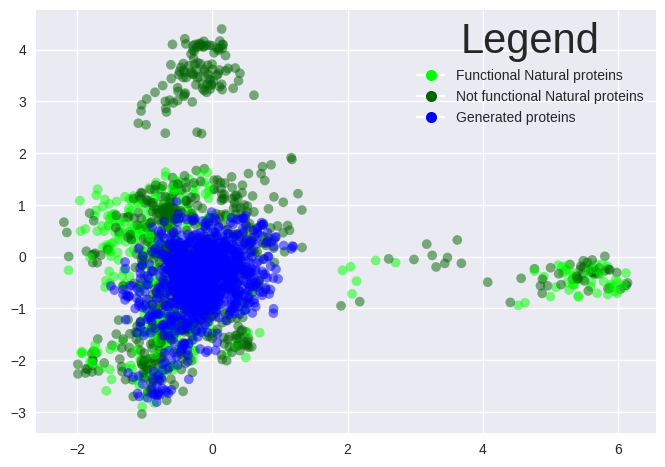

In [88]:
colors = ['lime' if val == 1 else 'darkgreen' for val in fct]
plt.scatter(nat_2d_pca[:, 0], nat_2d_pca[:, 1], c=colors, edgecolor='none', alpha=0.5)
plt.scatter(proteins_2d_pca[:,0],proteins_2d_pca[:,1],c='b', edgecolor='none', alpha=0.5)
legend_labels = ['Functional Natural proteins ', 'Not functional Natural proteins','Generated proteins']
legend_colors = ['Lime', 'Darkgreen','Blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
plt.show()

Text(0.5, 0, '3° p. component')

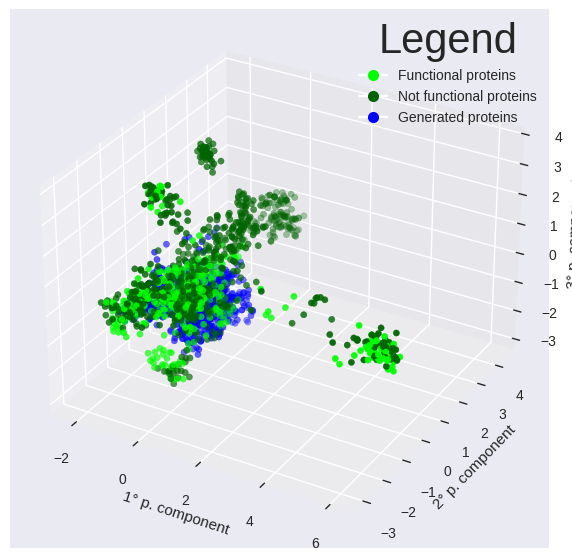

In [89]:
pca3=PCA(n_components=3)
nat_2d_pca_3d = pca3.fit_transform(nat_2d)
proteins_2d_pca3=pca3.transform(proteine_2d)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(nat_2d_pca_3d[:,0], nat_2d_pca_3d[:,1], nat_2d_pca_3d[:,2], c=colors)
ax.scatter(proteins_2d_pca3[:,0], proteins_2d_pca3[:,1], proteins_2d_pca3[:,2], c='b')
legend_labels = ['Functional proteins', 'Not functional proteins','Generated proteins']
legend_colors = ['Lime', 'Darkgreen','Blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')
ax.set_xlabel('1° p. component')
ax.set_ylabel('2° p. component')
ax.set_zlabel('3° p. component')


##### Clustering
Before the clustering methods have been unable to distiguish between functional and non functional proteins. While it can be useful to use to understand if the clustering methods are able to distinguish the natural sequences from the generated ones



In [90]:
nat_generated = np.concatenate((nat_2d, proteine_2d))
np.shape(nat_generated)

(2130, 1920)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


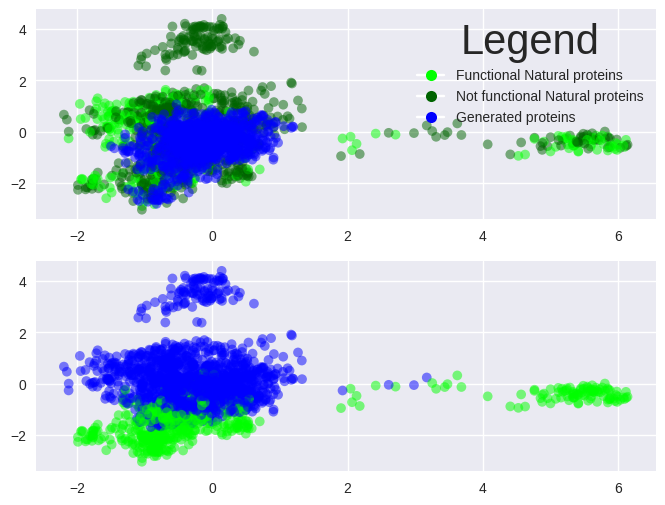

In [91]:
g_2=KMeans(2) # Clustering with 2
g_2.fit(nat_generated)
y_modelg_2=g_2.predict(nat_generated)
Nat_gen_pca = pca.transform(nat_generated)
#Adding two subplot
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
colors = ['lime' if val == 1 else 'darkgreen' for val in fct]
axs[0].scatter(nat_2d_pca[:, 0], nat_2d_pca[:, 1], c=colors, edgecolor='none', alpha=0.5)
axs[0].scatter(proteins_2d_pca[:,0],proteins_2d_pca[:,1],c='b', edgecolor='none', alpha=0.5)
legend_labels = ['Functional Natural proteins ', 'Not functional Natural proteins','Generated proteins']
legend_colors = ['Lime', 'Darkgreen','Blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
axs[0].legend(handles=legend_handles, title='Legend', loc='upper right')
# We use PCA of before to project

axs[1].scatter(Nat_gen_pca[:, 0],Nat_gen_pca[:, 1], c=y_modelg_2, edgecolor='none', alpha=0.5,
            cmap='brg')
plt.show()

(2130,)


<ipython-input-92-02e2755b186b>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Nat_gen_pca[:, 0],Nat_gen_pca[:, 1], c=color_gen, edgecolor='none', alpha=0.5,cmap='brg')


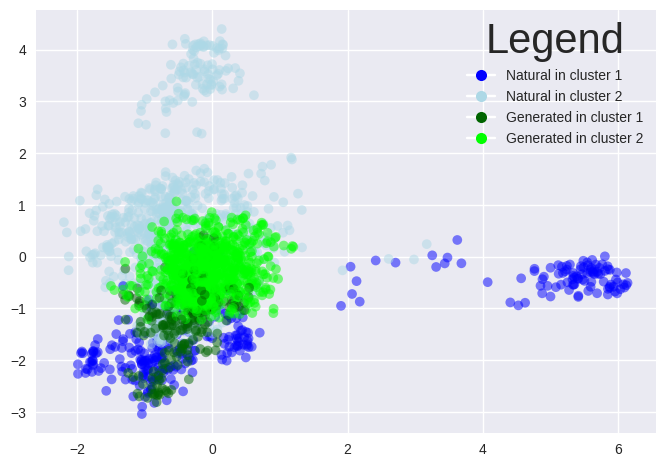

In [92]:
print(y_modelg_2.shape)
color_gen=[]
number_of_generated_cl1=0
number_of_generated_cl2=0
for i in range(len(nat_2d)):
    if y_modelg_2[i] == 1:
        color_gen.append('blue')

    else:
        color_gen.append('lightblue')

for i in range(len(nat_2d),len(nat_generated)):
    if y_modelg_2[i] == 1:
        color_gen.append('Darkgreen')
        number_of_generated_cl1+=1
    else:
        color_gen.append('Lime')
        number_of_generated_cl2+=1

plt.scatter(Nat_gen_pca[:, 0],Nat_gen_pca[:, 1], c=color_gen, edgecolor='none', alpha=0.5,cmap='brg')
legend_labels = ['Natural in cluster 1', 'Natural in cluster 2','Generated in cluster 1','Generated in cluster 2']
legend_colors = ['Blue', 'lightblue','Darkgreen','Lime']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')



In [93]:
print('Number of generated proteins in cluster 1=',number_of_generated_cl1)
print()
print('Number of generated proteins in cluster 2=',number_of_generated_cl2)

Number of generated proteins in cluster 1= 211

Number of generated proteins in cluster 2= 789


<!-- Most of the generated proteins are in cluster 1, with some natural proteins, while few of generated proteins are in cluster 2.
This can be explained probably by the fact that in the model we did not consider terms of fields, and also that our sample is very concentrated in a region of the Pca space. -->

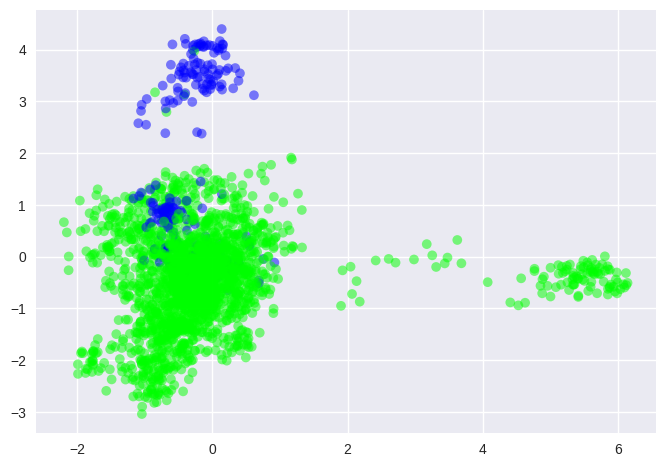

In [94]:
model_g=DBSCAN(eps=11, min_samples=50)
model_g.fit(nat_generated)
y_generated_db= model_g.labels_
plt.scatter(Nat_gen_pca[:, 0],Nat_gen_pca[:, 1], c=y_generated_db, edgecolor='none', alpha=0.5,
            cmap='brg')
plt.show()

[0 0 0 ... 0 0 0]


<ipython-input-95-e2d9d920970b>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Nat_gen_pca[:, 0],Nat_gen_pca[:, 1], c=color_gen_db, edgecolor='none', alpha=0.5,cmap='brg')


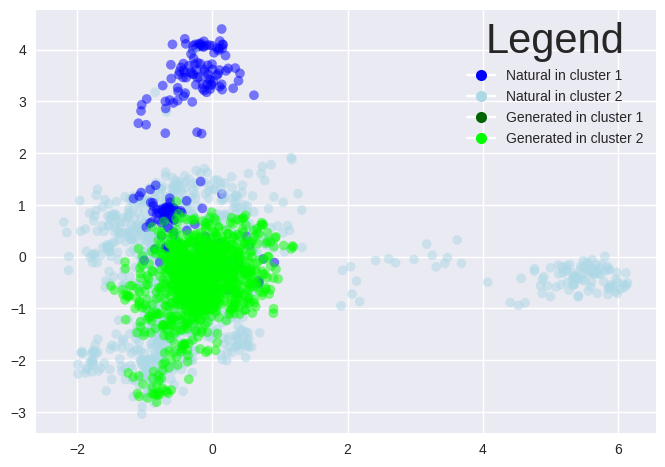

In [95]:
print(y_generated_db)
color_gen_db=[]
number_of_generated_cl1=0
number_of_generated_cl2=0
for i in range(1130):
    if y_generated_db[i] == -1:
        color_gen_db.append('blue')

    else:
        color_gen_db.append('lightblue')

for i in range(1130,2130):
    if y_generated_db[i] == 1:
        color_gen_db.append('Darkgreen')
        number_of_generated_cl1+=1
    else:
        color_gen_db.append('Lime')
        number_of_generated_cl2+=1

plt.scatter(Nat_gen_pca[:, 0],Nat_gen_pca[:, 1], c=color_gen_db, edgecolor='none', alpha=0.5,cmap='brg')
legend_labels = ['Natural in cluster 1', 'Natural in cluster 2','Generated in cluster 1','Generated in cluster 2']
legend_colors = ['Blue', 'lightblue','Darkgreen','Lime']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend', loc='upper right')


In [96]:
print('Number of generated proteins in cluster 1=',number_of_generated_cl1)
print()
print('Number of generated proteins in cluster 2=',number_of_generated_cl2)

Number of generated proteins in cluster 1= 0

Number of generated proteins in cluster 2= 1000


##### Predicting proteins functionality
Let's try to deduce the functionality with the AdaBoost classifier trained in the previous task.

In [97]:
fct_pred = model_Ada.predict(proteine_2d)
np.sum(fct_pred)

490

There are 490 proteins predicted functional. Given the performance of the classifier, as shown in task 4, it is reasonable to assume that some of these proteins will actually be functional.
Let's check the consistency with the Logistic Regression Classifier.

In [98]:
prob=model_LR.predict_proba((proteine_2d))
y_pred_LR_g=np.zeros(np.shape(proteine_2d)[0])

for i in range(len(prob)):
     if prob[i,1]>=0.11:
       y_pred_LR_g[i]=1
     else:
       y_pred_LR_g[i]=0

# y_pred_LR_g=model_LR.predict(proteine_2d)

np.sum(y_pred_LR_g)

874.0